In [1]:
# uncomment local imports, comment google drive file import
# this version is not dependent on utils folder
# make changes by other

In [2]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
# !pip install torchinfo optuna

# **Imports**

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from tqdm.notebook import tqdm

import torchinfo
import optuna

# import nndl.models.CNN as cnn
# import nndl.models.CNNLSTM as clstm
# import nndl.models.GRU as gru
# import nndl.utils as utils
import time
import gc

In [4]:
# seeds
import random
random.seed(1337)
np.random.seed(1337)
torch.manual_seed(1337)

#random.seed(14399246544918688587)
#torch.manual_seed(14399246544918688587)
#np.random.seed(14399246544918688587)

In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


# **Load data from localhost**

In [6]:
X_test = np.load("./project_data/X_test.npy")
y_test = np.load("./project_data/y_test.npy") - 769
person_train_valid = np.load("./project_data/person_train_valid.npy")
X_train_valid = np.load("./project_data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
person_test = np.load("./project_data/person_test.npy")

print(X_train_valid.shape)
print(X_test.shape)

print(y_train_valid)

(2115, 22, 1000)
(2115, 22, 1000)
(443, 22, 1000)
[2 3 0 ... 3 3 2]


# Load data from google drive

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# ## Loading the dataset
# X_test = np.load("/content/drive/MyDrive/project_data/X_test.npy")
# y_test = np.load("/content/drive/MyDrive/project_data/y_test.npy")-769
# person_test = np.load("/content/drive/MyDrive/project_data/person_test.npy")
# X_train_valid = np.load("/content/drive/MyDrive/project_data/X_train_valid.npy")
# y_train_valid = np.load("/content/drive/MyDrive/project_data/y_train_valid.npy")-769
# person_train_valid = np.load("/content/drive/MyDrive/project_data/person_train_valid.npy")
# print("---all data---")
# print("X_test shape\t\t", X_test.shape)
# print("y_test shape\t\t", y_test.shape)
# print("person_test shape\t", person_test.shape)
# print("X_train_valid shape\t", X_train_valid.shape)
# print("y_train_valid shape\t", y_train_valid.shape)
# print("person_train_valid shape", person_train_valid.shape)
# print()

# Load data for a subset of subjects

In [9]:
# # subjects is to load a subset of the data for a particular subject
# subjects = [0, 1, 2, 3, 4, 5, 6, 7, 8] #use 0-8 for subjects 1-9
# # subjects = [0] #use 0-8 for subjects 1-9

# X_test_subs = np.empty((0, X_test.shape[1], X_test.shape[2]))
# y_test_subs = np.empty((0))
# X_train_valid_subs = np.empty((0, X_train_valid.shape[1], X_train_valid.shape[2]))
# y_train_valid_subs = np.empty((0))

# for i in subjects:
#   sub = i
#   X_test_subs = np.concatenate( (X_test_subs, X_test[np.where(person_test == sub)[0],:,:] ))
#   y_test_subs = np.concatenate( (y_test_subs, y_test[np.where(person_test == sub)[0]] ))
#   X_train_valid_subs = np.concatenate(( X_train_valid_subs, X_train_valid[np.where(person_train_valid == sub)[0], :, :] ))
#   y_train_valid_subs = np.concatenate(( y_train_valid_subs, y_train_valid[np.where(person_train_valid == sub)[0]] ))

# X_test = X_test_subs
# y_test = y_test_subs
# X_train_valid = X_train_valid_subs
# y_train_valid = y_train_valid_subs
# print("---after isolating subjects---")
# print("X_test shape\t\t", X_test.shape)
# print("y_test shape\t\t", y_test.shape)
# print("X_train_valid shape\t", X_train_valid.shape)
# print("y_train_valid shape\t", y_train_valid.shape)

# train_model and test_model functions

In [7]:
def train_model(model,
                criterion,
                optimizer,
                scheduler,
                train_loader=None,
                val_loader=None,
                test_loader=None,
                num_epochs=100,
                learning=False,
                device=torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'),
                trial=None):
    # we return these
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}')

        # ======================================================================
        # START OF TRAINING
        # ======================================================================
        model.train()
        train_count = 0
        train_correct_count = 0

        # minibatch
        for batch_idx, (train_x, train_y) in enumerate(tqdm(train_loader)):
            train_x = train_x.float().to(device)
            train_y = train_y.long().to(device)

            logits = model(train_x)
            loss = criterion(logits, train_y)

            optimizer.zero_grad()   # no gradient accumulation between batches
            loss.backward()         # backprop
            optimizer.step()        # gradient step

            # training accuracy
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=-1)
                train_correct_count += torch.sum(y_hat == train_y, axis=-1)
                train_count += train_x.size(0)

        train_acc = train_correct_count / train_count
        train_accuracies.append(train_acc.item())
        # ======================================================================
        # END OF TRAINING
        # ======================================================================

        # ======================================================================
        # START OF VALIDATION
        # ======================================================================
        model.eval()
        val_count = 0
        val_correct_count = 0
        val_loss = 0

        # validation accuracy
        with torch.no_grad():
            for idx, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.float().to(device)
                val_y = val_y.long().to(device)

                logits = model(val_x).detach()
                y_hat = torch.argmax(logits, dim=-1)

                val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                val_count += val_y.size(0)

                # for the learning rate scheduler
                val_loss = criterion(logits, val_y)

        val_acc = val_correct_count / val_count
        val_accuracies.append(val_acc.item())
        if type(scheduler).__name__ == 'CosineAnnealingLR':
            scheduler.step()
        else:
            scheduler.step(val_loss)
        # ======================================================================
        # END OF VALIDATION
        # ======================================================================

        # performance info
        print('Train acc: {:.3f}, Val acc: {:.3f}, Val loss: {:.3f}'.format(train_acc,
                                                                            val_acc,
                                                                            val_loss))

        if learning:
            # ======================================================================
            # START OF TRIAL PRUNING
            # ======================================================================
            trial.report(val_acc.item(), epoch)
            # so my gpu doesn't shit itself, also gets rid of shit trials
            if trial.should_prune():
                # garbage collection so my gpu doesn't shit itself
                del model
                torch.cuda.empty_cache()
                gc.collect()
                raise optuna.TrialPruned()
            # ======================================================================
            # START OF TRIAL PRUNING
            # ======================================================================

    if learning:
        # garbage collection so my gpu doesn't shit itself
        del model
        torch.cuda.empty_cache()
        gc.collect()

    return train_accuracies, val_accuracies
# ==============================================================================
# END OF train_model()
# ==============================================================================


# ==============================================================================
# START OF test_model()
# ==============================================================================
def test_model(model,
               test_loader,
               device=torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')):
    model.eval()
    with torch.no_grad():
        test_count = 0
        test_correct_count = 0

        for _, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.float().to(device)
            test_y = test_y.long().to(device)

            logits = model(test_x).detach()
            y_hat = torch.argmax(logits, dim=-1)

            test_correct_count += torch.sum(y_hat == test_y, axis=-1)
            test_count += test_x.size(0)

        test_acc = test_correct_count / test_count
        print('Test acc: {:.3f}'.format(test_acc))
# ==============================================================================
# END OF test_model()
# ==============================================================================

# **Data Prep**

In [8]:
def data_prep(X,y,sub_sample,average,noise,p_channel_dropout,smooth_time_mask,mask_length):

    total_X = None
    total_y = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    X_average = torch.mean(X.view(X.size(0), X.size(1), -1, average), axis=3)
    X_average = X_average + torch.normal(0.0, 0.5, X_average.shape)

    total_X = torch.cat((total_X, X_average), dim=0)
    total_y = torch.cat((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (torch.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = torch.cat((total_X, X_subsample), dim=0)
        print(total_y.view(-1,1).shape)
        print(y.view(-1,1).shape)
        total_y = torch.cat((total_y, y))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)

    if p_channel_dropout != 0:
        mask = (torch.rand(total_X.shape[0], total_X.shape[1]) >= p_channel_dropout).unsqueeze(2)
        X_dropout = mask * total_X
        total_X = torch.cat((total_X, X_dropout))
        total_y = torch.cat((total_y, total_y))

        print(f'Shape of X after channel dropout {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    if smooth_time_mask:
        copy_X = copy.deepcopy(total_X)
        starts = ((torch.rand(copy_X.shape[0])*(copy_X.shape[2]-mask_length-1))).round()
        for idx, m in enumerate(copy_X):
            start = int(starts[idx])
            end = start+mask_length
            m[:,start:end] = 0
        total_X = torch.cat((total_X, copy_X))
        total_y = torch.cat((total_y, total_y))
        print(f'Shape of X after smooth time mask {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    return total_X,total_y

def test_data_prep(X):
    total_X = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:', X.shape)
    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, 2), axis=3)
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    return total_X


input_size = 22
hidden_size = 256
num_layers = 10
num_classes = 4
learning_rate = 1e-4
batch_size = 64
num_epochs = 100
dropout = 0.3

folds = 10
split_seed = 1
subsample = 2
average = 2
p_channel_dropout = 0
smooth_time_mask = False
mask_size = 120
noise = False
'''
This was the old data prep.
The code below is just split up.
Split data, then split up X_train, X_val, X_test by subject and create dataloaders
Then dataprep and dataloader is performed for x_train etc
kept in case of error then can go back
i could have put them in lists
'''
'''
X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')
'''

X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
#print(indices)
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
#print(split_idx)
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

person_train_valid, person_test = torch.Tensor(person_train_valid), torch.Tensor(person_test)
person_train, person_valid = person_train_valid[indices[:split_idx]], person_train_valid[indices[split_idx:]]

#check it matches
'''
index_zero = (indices == 0).nonzero(as_tuple=False) #index in indices that hold index 0 in X_train_valid and person_train_valid
print(index_zero)
print(indices[index_zero])
if index_zero > 1902: #in validation
  print(X_train_valid[0])
  print(X_train[index_zero - 1903])
  print(person_train[index_zero - 1903])
  print(person_train_valid[0])
else:
  print(X_train_valid[0])
  print(X_train[index_zero])
  print(person_train[index_zero])
  print(person_train_valid[0])
'''

################################################
#seperate X_train by subject using person_train
################################################

s_train = [[], [], [], [], [], [], [], [], []]
s_y_train = [[], [], [], [], [], [], [], [], []]
count_train = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_train, range(len(person_train))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_train[int(i[0])].append(X_train[j])
  s_y_train[int(i[0])].append(y_train[j])

  #for length check
  count_train[int(i[0])]+=1

print('subject counts: ', count_train)
print('subject count sum: ', sum(count_train))

#lebron
for (i, j, k) in zip(count_train, s_train, s_y_train):
  if i != len(j) or i != len(k):
    print("length issue")


print('\nsubject 0')
s0_train, s0_y_train = data_prep(torch.Tensor(np.asarray(s_train[0])), torch.Tensor(np.asarray(s_y_train[0])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 1')
s1_train, s1_y_train = data_prep(torch.Tensor(np.asarray(s_train[1])), torch.Tensor(np.asarray(s_y_train[1])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 2')
s2_train, s2_y_train = data_prep(torch.Tensor(np.asarray(s_train[2])), torch.Tensor(np.asarray(s_y_train[2])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 3')
s3_train, s3_y_train = data_prep(torch.Tensor(np.asarray(s_train[3])), torch.Tensor(np.asarray(s_y_train[3])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 4')
s4_train, s4_y_train = data_prep(torch.Tensor(np.asarray(s_train[4])), torch.Tensor(np.asarray(s_y_train[4])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 5')
s5_train, s5_y_train = data_prep(torch.Tensor(np.asarray(s_train[5])), torch.Tensor(np.asarray(s_y_train[5])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 6')
s6_train, s6_y_train = data_prep(torch.Tensor(np.asarray(s_train[6])), torch.Tensor(np.asarray(s_y_train[6])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 7')
s7_train, s7_y_train = data_prep(torch.Tensor(np.asarray(s_train[7])), torch.Tensor(np.asarray(s_y_train[7])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 8')
s8_train, s8_y_train = data_prep(torch.Tensor(np.asarray(s_train[8])), torch.Tensor(np.asarray(s_y_train[8])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)

#############################################
#seperate X_val by subject using person_valid
#############################################please_work
Last Checkpoint: 54 minutes ago
[Python (linux-venv)]
# uncomment local imports, comment google drive file import
# this version is not dependent on utils folder
# make changes by other
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# !pip install torchinfo optuna
Imports
import numpy as np
import matplotlib.pyplot as plt

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from tqdm.notebook import tqdm

import torchinfo
import optuna

# import nndl.models.CNN as cnn
# import nndl.models.CNNLSTM as clstm
# import nndl.models.GRU as gru
# import nndl.utils as utils
import time
import gc
Selection deleted
# seeds
import random
random.seed(1337)
np.random.seed(1337)
torch.manual_seed(1337)

#random.seed(14399246544918688587)
#torch.manual_seed(14399246544918688587)
#np.random.seed(14399246544918688587)

<torch._C.Generator at 0x7934340c7dd0>

if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda

Load data from localhost
X_test = np.load("./project_data/X_test.npy")
y_test = np.load("./project_data/y_test.npy") - 769
person_train_valid = np.load("./project_data/person_train_valid.npy")
X_train_valid = np.load("./project_data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
person_test = np.load("./project_data/person_test.npy")

print(X_train_valid.shape)
print(X_test.shape)

print(y_train_valid)

(2115, 22, 1000)
(2115, 22, 1000)
(443, 22, 1000)
[2 3 0 ... 3 3 2]

Load data from google drive
Load data for a subset of subjects
train_model and test_model functions
        # ======================================================================
                                                                            val_loss))

        if learning:
            # ======================================================================
            # START OF TRIAL PRUNING
            # ======================================================================
            trial.report(val_acc.item(), epoch)
            # so my gpu doesn't shit itself, also gets rid of shit trials
            if trial.should_prune():
                # garbage collection so my gpu doesn't shit itself
                del model
                torch.cuda.empty_cache()
                gc.collect()
                raise optuna.TrialPruned()
            # ======================================================================
            # START OF TRIAL PRUNING
            # ======================================================================

    if learning:
        # garbage collection so my gpu doesn't shit itself
        del model
        torch.cuda.empty_cache()
        gc.collect()

    return train_accuracies, val_accuracies
# ==============================================================================
# END OF train_model()
# ==============================================================================


# ==============================================================================
# START OF test_model()
# ==============================================================================
def test_model(model,
               test_loader,
               device=torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')):
    model.eval()
    with torch.no_grad():
        test_count = 0
        test_correct_count = 0

        for _, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.float().to(device)
            test_y = test_y.long().to(device)

            logits = model(test_x).detach()
            y_hat = torch.argmax(logits, dim=-1)

            test_correct_count += torch.sum(y_hat == test_y, axis=-1)
            test_count += test_x.size(0)

        test_acc = test_correct_count / test_count
        print('Test acc: {:.3f}'.format(test_acc))
# ==============================================================================
# END OF test_model()
# ==============================================================================
Data Prep
s1_train_loader = DataLoader(TensorDataset(s1_train, s1_y_train), batch_size=batch_size, shuffle=True)
s1_val_loader = DataLoader(TensorDataset(s1_valid, s1_y_valid), batch_size=batch_size, shuffle=True)
s1_test_loader = DataLoader(TensorDataset(s1_test, s1_y_test), batch_size=batch_size, shuffle=True)

s2_train_loader = DataLoader(TensorDataset(s2_train, s2_y_train), batch_size=batch_size, shuffle=True)
s2_val_loader = DataLoader(TensorDataset(s2_valid, s2_y_valid), batch_size=batch_size, shuffle=True)
s2_test_loader = DataLoader(TensorDataset(s2_test, s2_y_test), batch_size=batch_size, shuffle=True)

s3_train_loader = DataLoader(TensorDataset(s3_train, s3_y_train), batch_size=batch_size, shuffle=True)
s3_val_loader = DataLoader(TensorDataset(s3_valid, s3_y_valid), batch_size=batch_size, shuffle=True)
s3_test_loader = DataLoader(TensorDataset(s3_test, s3_y_test), batch_size=batch_size, shuffle=True)

s4_train_loader = DataLoader(TensorDataset(s4_train, s4_y_train), batch_size=batch_size, shuffle=True)
s4_val_loader = DataLoader(TensorDataset(s4_valid, s4_y_valid), batch_size=batch_size, shuffle=True)
s4_test_loader = DataLoader(TensorDataset(s4_test, s4_y_test), batch_size=batch_size, shuffle=True)

s5_train_loader = DataLoader(TensorDataset(s5_train, s5_y_train), batch_size=batch_size, shuffle=True)
s5_val_loader = DataLoader(TensorDataset(s5_valid, s5_y_valid), batch_size=batch_size, shuffle=True)
s5_test_loader = DataLoader(TensorDataset(s5_test, s5_y_test), batch_size=batch_size, shuffle=True)

s6_train_loader = DataLoader(TensorDataset(s6_train, s6_y_train), batch_size=batch_size, shuffle=True)
s6_val_loader = DataLoader(TensorDataset(s6_valid, s6_y_valid), batch_size=batch_size, shuffle=True)
s6_test_loader = DataLoader(TensorDataset(s6_test, s6_y_test), batch_size=batch_size, shuffle=True)

s7_train_loader = DataLoader(TensorDataset(s7_train, s7_y_train), batch_size=batch_size, shuffle=True)
s7_val_loader = DataLoader(TensorDataset(s7_valid, s7_y_valid), batch_size=batch_size, shuffle=True)
s7_test_loader = DataLoader(TensorDataset(s7_test, s7_y_test), batch_size=batch_size, shuffle=True)

s8_train_loader = DataLoader(TensorDataset(s8_train, s8_y_train), batch_size=batch_size, shuffle=True)
s8_val_loader = DataLoader(TensorDataset(s8_valid, s8_y_valid), batch_size=batch_size, shuffle=True)
s8_test_loader = DataLoader(TensorDataset(s8_test, s8_y_test), batch_size=batch_size, shuffle=True)

subject_train_loader = [s0_train_loader, s1_train_loader, s2_train_loader, s3_train_loader, s4_train_loader, s5_train_loader, s6_train_loader, s7_train_loader,  s8_train_loader]
subject_val_loader = [s0_val_loader, s1_val_loader, s2_val_loader, s3_val_loader, s4_val_loader, s5_val_loader, s6_val_loader, s7_val_loader, s8_val_loader]
subject_test_loader = [s0_test_loader, s1_test_loader, s2_test_loader, s3_test_loader, s4_test_loader, s5_test_loader, s6_test_loader, s7_test_loader, s8_test_loader]


print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

SOME torch.Size([2115, 22, 1000])
subject counts:  [221, 212, 213, 208, 207, 203, 214, 216, 209]
subject count sum:  1903

subject 0
Shape of X after trimming: torch.Size([221, 22, 800])
Shape of X after maxpooling: torch.Size([221, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([442, 22, 400])
torch.Size([442, 1])
torch.Size([221, 1])
torch.Size([663, 1])
torch.Size([221, 1])
Shape of X after subsampling and concatenating: torch.Size([884, 22, 400])
Shape of Y: torch.Size([884])

subject 1
Shape of X after trimming: torch.Size([212, 22, 800])
Shape of X after maxpooling: torch.Size([212, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 400])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 400])
Shape of Y: torch.Size([848])

subject 2
Shape of X after trimming: torch.Size([213, 22, 800])
Shape of X after maxpooling: torch.Size([213, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([426, 22, 400])
torch.Size([426, 1])
torch.Size([213, 1])
torch.Size([639, 1])
torch.Size([213, 1])
Shape of X after subsampling and concatenating: torch.Size([852, 22, 400])
Shape of Y: torch.Size([852])

subject 3
Shape of X after trimming: torch.Size([208, 22, 800])
Shape of X after maxpooling: torch.Size([208, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([416, 22, 400])
torch.Size([416, 1])
torch.Size([208, 1])
torch.Size([624, 1])
torch.Size([208, 1])
Shape of X after subsampling and concatenating: torch.Size([832, 22, 400])
Shape of Y: torch.Size([832])

subject 4
Shape of X after trimming: torch.Size([207, 22, 800])
Shape of X after maxpooling: torch.Size([207, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([414, 22, 400])
torch.Size([414, 1])
torch.Size([207, 1])
torch.Size([621, 1])
torch.Size([207, 1])
Shape of X after subsampling and concatenating: torch.Size([828, 22, 400])
Shape of Y: torch.Size([828])

subject 5
Shape of X after trimming: torch.Size([203, 22, 800])
Shape of X after maxpooling: torch.Size([203, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([406, 22, 400])
torch.Size([406, 1])
torch.Size([203, 1])
torch.Size([609, 1])
torch.Size([203, 1])
Shape of X after subsampling and concatenating: torch.Size([812, 22, 400])
Shape of Y: torch.Size([812])

subject 6
Shape of X after trimming: torch.Size([214, 22, 800])
Shape of X after maxpooling: torch.Size([214, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([428, 22, 400])
torch.Size([428, 1])
torch.Size([214, 1])
torch.Size([642, 1])
torch.Size([214, 1])
Shape of X after subsampling and concatenating: torch.Size([856, 22, 400])
Shape of Y: torch.Size([856])

subject 7
Shape of X after trimming: torch.Size([216, 22, 800])
Shape of X after maxpooling: torch.Size([216, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([432, 22, 400])
torch.Size([432, 1])
torch.Size([216, 1])
torch.Size([648, 1])
torch.Size([216, 1])
Shape of X after subsampling and concatenating: torch.Size([864, 22, 400])
Shape of Y: torch.Size([864])

subject 8
Shape of X after trimming: torch.Size([209, 22, 800])
Shape of X after maxpooling: torch.Size([209, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([418, 22, 400])
torch.Size([418, 1])
torch.Size([209, 1])
torch.Size([627, 1])
torch.Size([209, 1])
Shape of X after subsampling and concatenating: torch.Size([836, 22, 400])
Shape of Y: torch.Size([836])
torch.Size([212, 22, 1000])
val counts:  [16, 24, 23, 26, 28, 33, 24, 16, 22]
val count sum:  212

subject 0
Shape of X after trimming: torch.Size([16, 22, 800])
Shape of X after maxpooling: torch.Size([16, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([32, 22, 400])
torch.Size([32, 1])
torch.Size([16, 1])
torch.Size([48, 1])
torch.Size([16, 1])
Shape of X after subsampling and concatenating: torch.Size([64, 22, 400])
Shape of Y: torch.Size([64])

subject 1
Shape of X after trimming: torch.Size([24, 22, 800])
Shape of X after maxpooling: torch.Size([24, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([48, 22, 400])
torch.Size([48, 1])
torch.Size([24, 1])
torch.Size([72, 1])
torch.Size([24, 1])
Shape of X after subsampling and concatenating: torch.Size([96, 22, 400])
Shape of Y: torch.Size([96])

subject 2
Shape of X after trimming: torch.Size([23, 22, 800])
Shape of X after maxpooling: torch.Size([23, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([46, 22, 400])
torch.Size([46, 1])
torch.Size([23, 1])
torch.Size([69, 1])
torch.Size([23, 1])
Shape of X after subsampling and concatenating: torch.Size([92, 22, 400])
Shape of Y: torch.Size([92])

subject 3
Shape of X after trimming: torch.Size([26, 22, 800])
Shape of X after maxpooling: torch.Size([26, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([52, 22, 400])
torch.Size([52, 1])
torch.Size([26, 1])
torch.Size([78, 1])
torch.Size([26, 1])
Shape of X after subsampling and concatenating: torch.Size([104, 22, 400])
Shape of Y: torch.Size([104])

subject 4
Shape of X after trimming: torch.Size([28, 22, 800])
Shape of X after maxpooling: torch.Size([28, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([56, 22, 400])
torch.Size([56, 1])
torch.Size([28, 1])
torch.Size([84, 1])
torch.Size([28, 1])
Shape of X after subsampling and concatenating: torch.Size([112, 22, 400])
Shape of Y: torch.Size([112])

subject 5
Shape of X after trimming: torch.Size([33, 22, 800])
Shape of X after maxpooling: torch.Size([33, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([66, 22, 400])
torch.Size([66, 1])
torch.Size([33, 1])
torch.Size([99, 1])
torch.Size([33, 1])
Shape of X after subsampling and concatenating: torch.Size([132, 22, 400])
Shape of Y: torch.Size([132])

subject 6
Shape of X after trimming: torch.Size([24, 22, 800])
Shape of X after maxpooling: torch.Size([24, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([48, 22, 400])
torch.Size([48, 1])
torch.Size([24, 1])
torch.Size([72, 1])
torch.Size([24, 1])
Shape of X after subsampling and concatenating: torch.Size([96, 22, 400])
Shape of Y: torch.Size([96])

subject 7
Shape of X after trimming: torch.Size([16, 22, 800])
Shape of X after maxpooling: torch.Size([16, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([32, 22, 400])
torch.Size([32, 1])
torch.Size([16, 1])
torch.Size([48, 1])
torch.Size([16, 1])
Shape of X after subsampling and concatenating: torch.Size([64, 22, 400])
Shape of Y: torch.Size([64])

subject 8
Shape of X after trimming: torch.Size([22, 22, 800])
Shape of X after maxpooling: torch.Size([22, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([44, 22, 400])
torch.Size([44, 1])
torch.Size([22, 1])
torch.Size([66, 1])
torch.Size([22, 1])
Shape of X after subsampling and concatenating: torch.Size([88, 22, 400])
Shape of Y: torch.Size([88])
torch.Size([443, 22, 1000])
test counts:  [50, 50, 50, 50, 47, 49, 50, 50, 47]
test count sum:  443

subject 0
Shape of X after trimming: torch.Size([50, 22, 800])
Shape of X after maxpooling: torch.Size([50, 22, 400])

subject 1
Shape of X after trimming: torch.Size([50, 22, 800])
Shape of X after maxpooling: torch.Size([50, 22, 400])

subject 2
Shape of X after trimming: torch.Size([50, 22, 800])
Shape of X after maxpooling: torch.Size([50, 22, 400])

subject 3
Shape of X after trimming: torch.Size([50, 22, 800])
Shape of X after maxpooling: torch.Size([50, 22, 400])

subject 4
Shape of X after trimming: torch.Size([47, 22, 800])
Shape of X after maxpooling: torch.Size([47, 22, 400])

subject 5
Shape of X after trimming: torch.Size([49, 22, 800])
Shape of X after maxpooling: torch.Size([49, 22, 400])

subject 6
Shape of X after trimming: torch.Size([50, 22, 800])
Shape of X after maxpooling: torch.Size([50, 22, 400])

subject 7
Shape of X after trimming: torch.Size([50, 22, 800])
Shape of X after maxpooling: torch.Size([50, 22, 400])

subject 8
Shape of X after trimming: torch.Size([47, 22, 800])
Shape of X after maxpooling: torch.Size([47, 22, 400])
Prepping Training Data
Shape of X after trimming: torch.Size([1903, 22, 800])
Shape of X after maxpooling: torch.Size([1903, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([3806, 22, 400])
torch.Size([3806, 1])
torch.Size([1903, 1])
torch.Size([5709, 1])
torch.Size([1903, 1])
Shape of X after subsampling and concatenating: torch.Size([7612, 22, 400])
Shape of Y: torch.Size([7612])

Prepping Validation Data
Shape of X after trimming: torch.Size([212, 22, 800])
Shape of X after maxpooling: torch.Size([212, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 400])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 400])
Shape of Y: torch.Size([848])

Prepping Test Data
Shape of X after trimming: torch.Size([443, 22, 800])
Shape of X after maxpooling: torch.Size([443, 22, 400])

FINISHED PREP

Final shape of training set: torch.Size([7612, 22, 400])
Final shape of validation set: torch.Size([848, 22, 400])
Final shape of test set: torch.Size([443, 22, 400])
TRAIN_DATA 119
VALID_DATA 14
TEST_DATA 7

# num_epochs = 50
# num_trials = 20
# start_time = time.time()
GRU
CNN
CNNLSTM
other
end
GOOD CNN
other cnn trying to seed
cnn seeded with augments
cnn seeded with augments cosine
cnn seeded with no augments cosine

number_epochs = 100
# batch size 64
# channel dropout 0.01
# noise True
# smooth_time_mask True
class CNN(nn.Module):
    def __init__(self, num_classes, dropout, kernel1, kernel2, kernel3, kernel4, pool_kernel):
        super(CNN, self).__init__()

        self.time_bins = 400
        self.magic_number = self.time_bins + kernel3 - 1

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=22, out_channels=25, kernel_size=kernel1),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(dropout)
        )

        self.L_pool = self.time_bins - kernel1 + 1

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=kernel2),
            nn.ELU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel2[1] + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=100, kernel_size=kernel3),
            nn.ELU(),
            nn.BatchNorm1d(100),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel3 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=self.magic_number, kernel_size=kernel4),
            nn.ELU(),
            nn.BatchNorm1d(self.magic_number),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel4 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.dense = nn.Linear(in_features= self.L_pool * self.magic_number, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)      # match dims for Conv2d().
        x = self.conv2(x)
        x = x.squeeze(2)        # match dims for Conv1d().
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1) # match dims for affine.
        x = self.dense(x)

        return F.log_softmax(x, dim=1)

from torchinfo import summary

model = CNN(num_classes=4,
          dropout=0.3647999634687216,
          kernel1=5,
          kernel2=(1, 25),
          kernel3=6,
          kernel4=5,
          pool_kernel=3).to(device)
summary(model, input_size=(batch_size, 22, 400))

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─Conv1d: 2-10                      [64, 100, 119]            30,100
│    └─ELU: 2-11                         [64, 100, 119]            --
│    └─BatchNorm1d: 2-12                 [64, 100, 119]            200
│    └─MaxPool1d: 2-13                   [64, 100, 39]             --
│    └─Dropout: 2-14                     [64, 100, 39]             --
├─Sequential: 1-4                        [64, 405, 11]             --
│    └─Conv1d: 2-15                      [64, 405, 35]             202,905
│    └─ELU: 2-16                         [64, 405, 35]             --
│    └─BatchNorm1d: 2-17                 [64, 405, 35]             810
│    └─MaxPool1d: 2-18                   [64, 405, 11]             --
│    └─Dropout: 2-19                     [64, 405, 11]             --
├─Linear: 1-5                            [64, 4]                   17,824
==========================================================================================
Total params: 286,064
Trainable params: 286,064
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.50
==========================================================================================
Input size (MB): 2.25
Forward/backward pass size (MB): 55.89
Params size (MB): 1.14
Estimated Total Size (MB): 59.28
==========================================================================================

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.0001)
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1

100%
 119/119 [00:02<00:00, 59.09it/s]

Train acc: 0.416, Val acc: 0.452, Val loss: 1.022
Epoch 2

100%
 119/119 [00:02<00:00, 59.40it/s]

Train acc: 0.564, Val acc: 0.565, Val loss: 0.841
Epoch 3

100%
 119/119 [00:02<00:00, 60.95it/s]

Train acc: 0.636, Val acc: 0.578, Val loss: 0.540
Epoch 4

100%
 119/119 [00:01<00:00, 61.04it/s]

Train acc: 0.693, Val acc: 0.608, Val loss: 0.566
Epoch 5

100%
 119/119 [00:02<00:00, 58.18it/s]

Train acc: 0.728, Val acc: 0.642, Val loss: 0.493
Epoch 6

100%
 119/119 [00:01<00:00, 59.87it/s]

Train acc: 0.765, Val acc: 0.660, Val loss: 0.519
Epoch 7

100%
 119/119 [00:02<00:00, 59.94it/s]

Train acc: 0.794, Val acc: 0.683, Val loss: 0.563
Epoch 8

100%
 119/119 [00:01<00:00, 60.27it/s]

Train acc: 0.818, Val acc: 0.658, Val loss: 0.765
Epoch 9

100%
 119/119 [00:02<00:00, 59.55it/s]

Train acc: 0.834, Val acc: 0.684, Val loss: 0.520
Epoch 10

100%
 119/119 [00:02<00:00, 59.74it/s]

Train acc: 0.855, Val acc: 0.718, Val loss: 0.515
Epoch 11

100%
 119/119 [00:02<00:00, 56.85it/s]

Train acc: 0.864, Val acc: 0.688, Val loss: 0.627
Epoch 12

100%
 119/119 [00:02<00:00, 58.33it/s]

Train acc: 0.889, Val acc: 0.700, Val loss: 0.543
Epoch 13

100%
 119/119 [00:01<00:00, 60.98it/s]

Train acc: 0.893, Val acc: 0.710, Val loss: 0.477
Epoch 14

100%
 119/119 [00:02<00:00, 60.45it/s]

Train acc: 0.906, Val acc: 0.699, Val loss: 0.648
Epoch 15

100%
 119/119 [00:02<00:00, 58.61it/s]

Train acc: 0.912, Val acc: 0.706, Val loss: 0.719
Epoch 16

100%
 119/119 [00:01<00:00, 61.18it/s]

Train acc: 0.921, Val acc: 0.691, Val loss: 0.758
Epoch 17

100%
 119/119 [00:02<00:00, 59.42it/s]

Train acc: 0.933, Val acc: 0.704, Val loss: 0.713
Epoch 18

100%
 119/119 [00:02<00:00, 60.56it/s]

Train acc: 0.933, Val acc: 0.709, Val loss: 0.694
Epoch 19

100%
 119/119 [00:01<00:00, 61.29it/s]

Train acc: 0.938, Val acc: 0.688, Val loss: 0.745
Epoch 20

100%
 119/119 [00:01<00:00, 60.56it/s]

Train acc: 0.941, Val acc: 0.686, Val loss: 0.779
Epoch 21

100%
 119/119 [00:02<00:00, 60.54it/s]

Train acc: 0.945, Val acc: 0.695, Val loss: 0.719
Epoch 22

100%
 119/119 [00:02<00:00, 56.18it/s]

Train acc: 0.945, Val acc: 0.672, Val loss: 0.750
Epoch 23

100%
 119/119 [00:02<00:00, 59.56it/s]

Train acc: 0.952, Val acc: 0.690, Val loss: 0.702
Epoch 24

100%
 119/119 [00:02<00:00, 58.67it/s]

Train acc: 0.955, Val acc: 0.693, Val loss: 0.763
Epoch 25

100%
 119/119 [00:02<00:00, 56.58it/s]

Train acc: 0.955, Val acc: 0.690, Val loss: 0.740
Epoch 26

100%
 119/119 [00:02<00:00, 55.36it/s]

Train acc: 0.955, Val acc: 0.689, Val loss: 0.721
Epoch 27

100%
 119/119 [00:01<00:00, 60.31it/s]

Train acc: 0.956, Val acc: 0.683, Val loss: 0.770
Epoch 28

100%
 119/119 [00:02<00:00, 56.47it/s]

Train acc: 0.959, Val acc: 0.692, Val loss: 0.795
Epoch 29

100%
 119/119 [00:02<00:00, 59.22it/s]

Train acc: 0.956, Val acc: 0.692, Val loss: 0.798
Epoch 30

100%
 119/119 [00:02<00:00, 60.87it/s]

Train acc: 0.958, Val acc: 0.715, Val loss: 0.831
Epoch 31

100%
 119/119 [00:02<00:00, 58.89it/s]

Train acc: 0.958, Val acc: 0.711, Val loss: 0.756
Epoch 32

100%
 119/119 [00:01<00:00, 62.26it/s]

Train acc: 0.958, Val acc: 0.698, Val loss: 0.831
Epoch 33

100%
 119/119 [00:02<00:00, 60.34it/s]

Train acc: 0.954, Val acc: 0.705, Val loss: 0.794
Epoch 34

100%
 119/119 [00:01<00:00, 61.84it/s]

Train acc: 0.955, Val acc: 0.710, Val loss: 0.874
Epoch 35

100%
 119/119 [00:01<00:00, 62.43it/s]

Train acc: 0.949, Val acc: 0.698, Val loss: 0.760
Epoch 36

100%
 119/119 [00:01<00:00, 60.55it/s]

Train acc: 0.951, Val acc: 0.698, Val loss: 0.849
Epoch 37

100%
 119/119 [00:01<00:00, 62.56it/s]

Train acc: 0.951, Val acc: 0.709, Val loss: 0.674
Epoch 38

100%
 119/119 [00:01<00:00, 63.51it/s]

Train acc: 0.947, Val acc: 0.698, Val loss: 0.868
Epoch 39

100%
 119/119 [00:02<00:00, 54.99it/s]

Train acc: 0.942, Val acc: 0.706, Val loss: 0.690
Epoch 40

100%
 119/119 [00:02<00:00, 60.61it/s]

Train acc: 0.938, Val acc: 0.708, Val loss: 0.780
Epoch 41

100%
 119/119 [00:01<00:00, 62.77it/s]

Train acc: 0.943, Val acc: 0.723, Val loss: 0.964
Epoch 42

100%
 119/119 [00:01<00:00, 62.92it/s]

Train acc: 0.938, Val acc: 0.688, Val loss: 0.732
Epoch 43

100%
 119/119 [00:01<00:00, 63.64it/s]

Train acc: 0.934, Val acc: 0.717, Val loss: 0.608
Epoch 44

100%
 119/119 [00:01<00:00, 63.73it/s]

Train acc: 0.936, Val acc: 0.709, Val loss: 0.821
Epoch 45

100%
 119/119 [00:01<00:00, 62.56it/s]

Train acc: 0.931, Val acc: 0.685, Val loss: 0.960
Epoch 46

100%
 119/119 [00:01<00:00, 63.13it/s]

Train acc: 0.942, Val acc: 0.686, Val loss: 0.810
Epoch 47

100%
 119/119 [00:01<00:00, 62.41it/s]

Train acc: 0.937, Val acc: 0.728, Val loss: 0.756
Epoch 48

100%
 119/119 [00:01<00:00, 63.56it/s]

Train acc: 0.936, Val acc: 0.663, Val loss: 0.800
Epoch 49

100%
 119/119 [00:01<00:00, 63.38it/s]

Train acc: 0.938, Val acc: 0.704, Val loss: 0.868
Epoch 50

100%
 119/119 [00:01<00:00, 62.56it/s]

Train acc: 0.942, Val acc: 0.683, Val loss: 0.896
Epoch 51

100%
 119/119 [00:01<00:00, 63.46it/s]

Train acc: 0.942, Val acc: 0.690, Val loss: 0.841
Epoch 52

100%
 119/119 [00:01<00:00, 62.38it/s]

Train acc: 0.945, Val acc: 0.690, Val loss: 0.825
Epoch 53

100%
 119/119 [00:01<00:00, 62.52it/s]

Train acc: 0.944, Val acc: 0.658, Val loss: 1.055
Epoch 54

100%
 119/119 [00:01<00:00, 63.91it/s]

Train acc: 0.941, Val acc: 0.703, Val loss: 0.690
Epoch 55

100%
 119/119 [00:01<00:00, 63.51it/s]

Train acc: 0.952, Val acc: 0.672, Val loss: 0.744
Epoch 56

100%
 119/119 [00:01<00:00, 64.14it/s]

Train acc: 0.951, Val acc: 0.680, Val loss: 0.654
Epoch 57

100%
 119/119 [00:01<00:00, 63.77it/s]

Train acc: 0.957, Val acc: 0.717, Val loss: 0.832
Epoch 58

100%
 119/119 [00:01<00:00, 63.53it/s]

Train acc: 0.958, Val acc: 0.715, Val loss: 0.586
Epoch 59

100%
 119/119 [00:01<00:00, 64.37it/s]

Train acc: 0.959, Val acc: 0.722, Val loss: 0.660
Epoch 60

100%
 119/119 [00:01<00:00, 64.23it/s]

Train acc: 0.962, Val acc: 0.704, Val loss: 0.847
Epoch 61

100%
 119/119 [00:01<00:00, 63.99it/s]

Train acc: 0.967, Val acc: 0.715, Val loss: 0.690
Epoch 62

100%
 119/119 [00:01<00:00, 64.16it/s]

Train acc: 0.969, Val acc: 0.729, Val loss: 0.684
Epoch 63

100%
 119/119 [00:01<00:00, 64.08it/s]

Train acc: 0.972, Val acc: 0.741, Val loss: 0.636
Epoch 64

100%
 119/119 [00:01<00:00, 64.39it/s]

Train acc: 0.974, Val acc: 0.739, Val loss: 0.543
Epoch 65

100%
 119/119 [00:01<00:00, 62.77it/s]

Train acc: 0.977, Val acc: 0.703, Val loss: 0.694
Epoch 66

100%
 119/119 [00:01<00:00, 62.89it/s]

Train acc: 0.978, Val acc: 0.721, Val loss: 0.741
Epoch 67

100%
 119/119 [00:01<00:00, 63.12it/s]

Train acc: 0.981, Val acc: 0.749, Val loss: 0.592
Epoch 68

100%
 119/119 [00:01<00:00, 61.90it/s]

Train acc: 0.984, Val acc: 0.718, Val loss: 0.761
Epoch 69

100%
 119/119 [00:01<00:00, 63.15it/s]

Train acc: 0.985, Val acc: 0.742, Val loss: 0.582
Epoch 70

100%
 119/119 [00:01<00:00, 62.69it/s]

Train acc: 0.986, Val acc: 0.733, Val loss: 0.602
Epoch 71

100%
 119/119 [00:01<00:00, 63.24it/s]

Train acc: 0.986, Val acc: 0.732, Val loss: 0.634
Epoch 72

100%
 119/119 [00:01<00:00, 63.44it/s]

Train acc: 0.987, Val acc: 0.715, Val loss: 0.718
Epoch 73

100%
 119/119 [00:01<00:00, 62.44it/s]

Train acc: 0.990, Val acc: 0.725, Val loss: 0.658
Epoch 74

100%
 119/119 [00:01<00:00, 63.21it/s]

Train acc: 0.988, Val acc: 0.722, Val loss: 0.713
Epoch 75

100%
 119/119 [00:01<00:00, 62.76it/s]

Train acc: 0.988, Val acc: 0.730, Val loss: 0.698
Epoch 76

100%
 119/119 [00:01<00:00, 61.93it/s]

Train acc: 0.990, Val acc: 0.721, Val loss: 0.746
Epoch 77

100%
 119/119 [00:01<00:00, 62.26it/s]

Train acc: 0.991, Val acc: 0.733, Val loss: 0.730
Epoch 78

100%
 119/119 [00:01<00:00, 62.39it/s]

Train acc: 0.991, Val acc: 0.735, Val loss: 0.672
Epoch 79

100%
 119/119 [00:01<00:00, 62.22it/s]

Train acc: 0.991, Val acc: 0.735, Val loss: 0.687
Epoch 80

100%
 119/119 [00:01<00:00, 59.44it/s]

Train acc: 0.989, Val acc: 0.725, Val loss: 0.694
Epoch 81

100%
 119/119 [00:01<00:00, 63.51it/s]

Train acc: 0.989, Val acc: 0.722, Val loss: 0.701
Epoch 82

100%
 119/119 [00:01<00:00, 63.99it/s]

Train acc: 0.987, Val acc: 0.730, Val loss: 0.636
Epoch 83

100%
 119/119 [00:01<00:00, 62.98it/s]

Train acc: 0.987, Val acc: 0.728, Val loss: 0.646
Epoch 84

100%
 119/119 [00:01<00:00, 62.26it/s]

Train acc: 0.986, Val acc: 0.724, Val loss: 0.681
Epoch 85

100%
 119/119 [00:01<00:00, 63.22it/s]

Train acc: 0.985, Val acc: 0.733, Val loss: 0.661
Epoch 86

100%
 119/119 [00:01<00:00, 63.36it/s]

Train acc: 0.980, Val acc: 0.728, Val loss: 0.639
Epoch 87

100%
 119/119 [00:01<00:00, 61.70it/s]

Train acc: 0.980, Val acc: 0.724, Val loss: 0.573
Epoch 88

100%
 119/119 [00:01<00:00, 63.43it/s]

Train acc: 0.976, Val acc: 0.749, Val loss: 0.532
Epoch 89

100%
 119/119 [00:01<00:00, 63.93it/s]

Train acc: 0.973, Val acc: 0.709, Val loss: 0.729
Epoch 90

100%
 119/119 [00:01<00:00, 64.23it/s]

Train acc: 0.966, Val acc: 0.685, Val loss: 0.519
Epoch 91

100%
 119/119 [00:01<00:00, 62.71it/s]

Train acc: 0.962, Val acc: 0.732, Val loss: 0.646
Epoch 92

100%
 119/119 [00:01<00:00, 62.53it/s]

Train acc: 0.964, Val acc: 0.699, Val loss: 0.606
Epoch 93

100%
 119/119 [00:01<00:00, 63.91it/s]

Train acc: 0.960, Val acc: 0.736, Val loss: 0.617
Epoch 94

100%
 119/119 [00:01<00:00, 64.42it/s]

Train acc: 0.957, Val acc: 0.716, Val loss: 0.691
Epoch 95

100%
 119/119 [00:01<00:00, 63.29it/s]

Train acc: 0.956, Val acc: 0.710, Val loss: 1.038
Epoch 96

100%
 119/119 [00:01<00:00, 64.71it/s]

Train acc: 0.957, Val acc: 0.711, Val loss: 0.743
Epoch 97

100%
 119/119 [00:01<00:00, 64.45it/s]

Train acc: 0.957, Val acc: 0.710, Val loss: 0.735
Epoch 98

100%
 119/119 [00:01<00:00, 63.70it/s]

Train acc: 0.958, Val acc: 0.746, Val loss: 0.461
Epoch 99

100%
 119/119 [00:01<00:00, 62.75it/s]

Train acc: 0.954, Val acc: 0.736, Val loss: 0.476
Epoch 100

100%
 119/119 [00:01<00:00, 63.38it/s]

Train acc: 0.956, Val acc: 0.706, Val loss: 0.706

import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
test_model(model, test_loader)

Test acc: 0.716

torch.save(model, './hopefully_better/cnn-seeded-noaugment-cosine')
cnn lstm
Selection deleted
class CLSTM(nn.Module):
    def __init__(self,
                 num_classes=4,
                 in_channels=22,
                 depth=25,
                 kernel1=3,
                 kernel2=(1, 22),
                 kernel3=5,
                 kernel4=5,
                 pool_kernel=(1, 3),
                 dropout=0.6,
                 hidden_dims=128,
                 num_layers=2):
        super(CLSTM, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=in_channels,
                                             out_channels=depth,
                                             kernel_size=kernel1,
                                             padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(depth),
                                   nn.Dropout(dropout))

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=depth,
                                             out_channels=depth*2,
                                             kernel_size=kernel2,
                                             stride=2),
                                   nn.ELU(),
                                   nn.BatchNorm2d(depth * 2),
                                   nn.AvgPool2d(kernel_size=(1, 3)),
                                   nn.Dropout(dropout))

        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=depth*2,
                                             out_channels=depth*4,
                                             kernel_size=kernel3),
                                   nn.ELU(),
                                   nn.BatchNorm1d(depth * 4),
                                   nn.AvgPool2d(kernel_size=pool_kernel),
                                   nn.Dropout(dropout))

        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=depth*4,
                                             out_channels=depth*8,
                                             kernel_size=kernel4,
                                             stride=3),
                                   nn.ELU(),
                                   nn.BatchNorm1d(depth * 8),
                                   nn.MaxPool2d(kernel_size=pool_kernel),
                                   nn.Dropout(dropout))

        self.lstm = nn.LSTM(input_size=depth*8,
                            hidden_size=hidden_dims,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout,
                            bias=True,
                            bidirectional=True)
        self.dense = nn.Linear(in_features=hidden_dims * 2,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
    
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
    
        x = self.conv3(x)
        x = self.conv4(x)
    
        x = torch.flatten(x, 1)
        x, _ = self.lstm(x)
        x = self.dense(x)
    
        return F.log_softmax(x, dim=1)

Selection deleted
from torchinfo import summary

model = CLSTM().to(device)
summary(model, input_size=(batch_size, 22, 400))

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
CLSTM                                    [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 400]             --
│    └─Conv1d: 2-1                       [64, 25, 400]             1,675
│    └─ReLU: 2-2                         [64, 25, 400]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 400]             50
│    └─Dropout: 2-4                      [64, 25, 400]             --
├─Sequential: 1-2                        [64, 50, 1, 63]           --
│    └─Conv2d: 2-5                       [64, 50, 1, 190]          27,550
│    └─ELU: 2-6                          [64, 50, 1, 190]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 190]          100
│    └─AvgPool2d: 2-8                    [64, 50, 1, 63]           --
│    └─Dropout: 2-9                      [64, 50, 1, 63]           --
├─Sequential: 1-3                        [64, 100, 19]             --
│    └─Conv1d: 2-10                      [64, 100, 59]             25,100
│    └─ELU: 2-11                         [64, 100, 59]             --
│    └─BatchNorm1d: 2-12                 [64, 100, 59]             200
│    └─AvgPool2d: 2-13                   [64, 100, 19]             --
│    └─Dropout: 2-14                     [64, 100, 19]             --
├─Sequential: 1-4                        [64, 200, 1]              --
│    └─Conv1d: 2-15                      [64, 200, 5]              100,200
│    └─ELU: 2-16                         [64, 200, 5]              --
│    └─BatchNorm1d: 2-17                 [64, 200, 5]              400
│    └─MaxPool2d: 2-18                   [64, 200, 1]              --
│    └─Dropout: 2-19                     [64, 200, 1]              --
├─LSTM: 1-5                              [64, 256]                 733,184
├─Linear: 1-6                            [64, 4]                   1,028
==========================================================================================
Total params: 889,487
Trainable params: 889,487
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 12.52
==========================================================================================
Input size (MB): 2.25
Forward/backward pass size (MB): 27.17
Params size (MB): 3.56
Estimated Total Size (MB): 32.98
==========================================================================================

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.0001)
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1

100%
 119/119 [00:02<00:00, 44.52it/s]

Train acc: 0.264, Val acc: 0.249, Val loss: 1.376
Epoch 2

100%
 119/119 [00:02<00:00, 44.44it/s]

Train acc: 0.306, Val acc: 0.269, Val loss: 1.263
Epoch 3

100%
 119/119 [00:02<00:00, 44.57it/s]

Train acc: 0.342, Val acc: 0.347, Val loss: 1.212
Epoch 4

100%
 119/119 [00:02<00:00, 43.19it/s]

Train acc: 0.370, Val acc: 0.401, Val loss: 1.244
Epoch 5

100%
 119/119 [00:02<00:00, 41.52it/s]

Train acc: 0.385, Val acc: 0.416, Val loss: 1.237
Epoch 6

100%
 119/119 [00:02<00:00, 43.60it/s]

Train acc: 0.412, Val acc: 0.420, Val loss: 1.159
Epoch 7

100%
 119/119 [00:02<00:00, 44.59it/s]

Train acc: 0.421, Val acc: 0.417, Val loss: 1.219
Epoch 8

100%
 119/119 [00:02<00:00, 42.65it/s]

Train acc: 0.429, Val acc: 0.438, Val loss: 1.195
Epoch 9

100%
 119/119 [00:02<00:00, 42.60it/s]

Train acc: 0.433, Val acc: 0.443, Val loss: 1.140
Epoch 10

100%
 119/119 [00:02<00:00, 43.02it/s]

Train acc: 0.449, Val acc: 0.432, Val loss: 1.140
Epoch 11

100%
 119/119 [00:02<00:00, 42.76it/s]

Train acc: 0.451, Val acc: 0.436, Val loss: 1.207
Epoch 12

100%
 119/119 [00:03<00:00, 38.40it/s]

Train acc: 0.452, Val acc: 0.449, Val loss: 1.238
Epoch 13

100%
 119/119 [00:02<00:00, 42.85it/s]

Train acc: 0.468, Val acc: 0.422, Val loss: 1.198
Epoch 14

100%
 119/119 [00:03<00:00, 38.75it/s]

Train acc: 0.458, Val acc: 0.452, Val loss: 1.224
Epoch 15

100%
 119/119 [00:03<00:00, 33.70it/s]

Train acc: 0.470, Val acc: 0.460, Val loss: 1.149
Epoch 16

100%
 119/119 [00:03<00:00, 41.43it/s]

Train acc: 0.479, Val acc: 0.425, Val loss: 1.160
Epoch 17

100%
 119/119 [00:02<00:00, 42.66it/s]

Train acc: 0.478, Val acc: 0.463, Val loss: 1.186
Epoch 18

100%
 119/119 [00:02<00:00, 39.66it/s]

Train acc: 0.486, Val acc: 0.465, Val loss: 1.100
Epoch 19

100%
 119/119 [00:02<00:00, 41.94it/s]

Train acc: 0.484, Val acc: 0.458, Val loss: 1.162
Epoch 20

100%
 119/119 [00:02<00:00, 40.93it/s]

Train acc: 0.483, Val acc: 0.482, Val loss: 1.130
Epoch 21

100%
 119/119 [00:02<00:00, 40.06it/s]

Train acc: 0.495, Val acc: 0.475, Val loss: 1.105
Epoch 22

100%
 119/119 [00:02<00:00, 39.66it/s]

Train acc: 0.485, Val acc: 0.465, Val loss: 1.152
Epoch 23

100%
 119/119 [00:02<00:00, 42.47it/s]

Train acc: 0.494, Val acc: 0.483, Val loss: 1.095
Epoch 24

100%
 119/119 [00:02<00:00, 44.91it/s]

Train acc: 0.498, Val acc: 0.489, Val loss: 1.118
Epoch 25

100%
 119/119 [00:02<00:00, 42.00it/s]

Show more outputs

import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
test_model(model, test_loader)

Test acc: 0.413

torch.save(model, './hopefully_better/clstm-seeded-noaugment-cosine')

Select Kernel
Select kernel for: "Console 1"

print(X_valid.shape)

s_valid = [[], [], [], [], [], [], [], [], []]
s_y_valid = [[], [], [], [], [], [], [], [], []]
count_val = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_valid, range(len(person_valid))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_valid[int(i[0])].append(X_valid[j])
  s_y_valid[int(i[0])].append(y_valid[j])

  #for length check
  count_val[int(i[0])]+=1

print('val counts: ', count_val)
print('val count sum: ', sum(count_val))

#lebron
for (i, j, k) in zip(count_val, s_valid, s_y_valid):
  if i != len(j) or i != len(k):
    print("length issue")

print('\nsubject 0')
s0_valid, s0_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[0])), torch.Tensor(np.asarray(s_y_valid[0])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 1')
s1_valid, s1_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[1])), torch.Tensor(np.asarray(s_y_valid[1])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 2')
s2_valid, s2_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[2])), torch.Tensor(np.asarray(s_y_valid[2])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 3')
s3_valid, s3_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[3])), torch.Tensor(np.asarray(s_y_valid[3])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 4')
s4_valid, s4_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[4])), torch.Tensor(np.asarray(s_y_valid[4])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 5')
s5_valid, s5_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[5])), torch.Tensor(np.asarray(s_y_valid[5])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 6')
s6_valid, s6_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[6])), torch.Tensor(np.asarray(s_y_valid[6])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 7')
s7_valid, s7_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[7])), torch.Tensor(np.asarray(s_y_valid[7])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 8')
s8_valid, s8_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[8])), torch.Tensor(np.asarray(s_y_valid[8])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)

#############################################
#seperate X_test by subject using person_test
#############################################
print(X_test.shape)

s_test = [[], [], [], [], [], [], [], [], []]
s_y_test = [[], [], [], [], [], [], [], [], []]
count_test = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_test, range(len(person_test))):
  #i is a np.darray from person_test, i[0] gives us the subject
  #j is the index of i in person_test that corresponds to the index in X_test
  s_test[int(i[0])].append(X_test[j])
  s_y_test[int(i[0])].append(y_test[j])

  #for length check
  count_test[int(i[0])]+=1

print('test counts: ', count_test)
print('test count sum: ', sum(count_test))

#lebron length check
for (i, j, k) in zip(count_test, s_test, s_y_test):
  if i != len(j) or i != len(k):
    print("length issue")

#Look in my eyes, tell me your tale Do you see the road, the map to my soul? Look, tell me the signs whenever the smoke clear out of my face Am I picture-perfect or do I look fried?
print('\nsubject 0')
s0_test, s0_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[0]))), torch.Tensor(np.asarray(s_y_test[0]))
print('\nsubject 1')
s1_test, s1_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[1]))), torch.Tensor(np.asarray(s_y_test[1]))
print('\nsubject 2')
s2_test, s2_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[2]))), torch.Tensor(np.asarray(s_y_test[2]))
print('\nsubject 3')
s3_test, s3_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[3]))), torch.Tensor(np.asarray(s_y_test[3]))
print('\nsubject 4')
s4_test, s4_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[4]))), torch.Tensor(np.asarray(s_y_test[4]))
print('\nsubject 5')
s5_test, s5_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[5]))), torch.Tensor(np.asarray(s_y_test[5]))
print('\nsubject 6')
s6_test, s6_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[6]))), torch.Tensor(np.asarray(s_y_test[6]))
print('\nsubject 7')
s7_test, s7_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[7]))), torch.Tensor(np.asarray(s_y_test[7]))
print('\nsubject 8')
s8_test, s8_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[8]))), torch.Tensor(np.asarray(s_y_test[8]))

#############################
#Generate Subject DataLoader#
#############################

s0_train_loader = DataLoader(TensorDataset(s0_train, s0_y_train), batch_size=batch_size, shuffle=True)
s0_val_loader = DataLoader(TensorDataset(s0_valid, s0_y_valid), batch_size=batch_size, shuffle=True)
s0_test_loader = DataLoader(TensorDataset(s0_test, s0_y_test), batch_size=batch_size, shuffle=True)

s1_train_loader = DataLoader(TensorDataset(s1_train, s1_y_train), batch_size=batch_size, shuffle=True)
s1_val_loader = DataLoader(TensorDataset(s1_valid, s1_y_valid), batch_size=batch_size, shuffle=True)
s1_test_loader = DataLoader(TensorDataset(s1_test, s1_y_test), batch_size=batch_size, shuffle=True)

s2_train_loader = DataLoader(TensorDataset(s2_train, s2_y_train), batch_size=batch_size, shuffle=True)
s2_val_loader = DataLoader(TensorDataset(s2_valid, s2_y_valid), batch_size=batch_size, shuffle=True)
s2_test_loader = DataLoader(TensorDataset(s2_test, s2_y_test), batch_size=batch_size, shuffle=True)

s3_train_loader = DataLoader(TensorDataset(s3_train, s3_y_train), batch_size=batch_size, shuffle=True)
s3_val_loader = DataLoader(TensorDataset(s3_valid, s3_y_valid), batch_size=batch_size, shuffle=True)
s3_test_loader = DataLoader(TensorDataset(s3_test, s3_y_test), batch_size=batch_size, shuffle=True)

s4_train_loader = DataLoader(TensorDataset(s4_train, s4_y_train), batch_size=batch_size, shuffle=True)
s4_val_loader = DataLoader(TensorDataset(s4_valid, s4_y_valid), batch_size=batch_size, shuffle=True)
s4_test_loader = DataLoader(TensorDataset(s4_test, s4_y_test), batch_size=batch_size, shuffle=True)

s5_train_loader = DataLoader(TensorDataset(s5_train, s5_y_train), batch_size=batch_size, shuffle=True)
s5_val_loader = DataLoader(TensorDataset(s5_valid, s5_y_valid), batch_size=batch_size, shuffle=True)
s5_test_loader = DataLoader(TensorDataset(s5_test, s5_y_test), batch_size=batch_size, shuffle=True)

s6_train_loader = DataLoader(TensorDataset(s6_train, s6_y_train), batch_size=batch_size, shuffle=True)
s6_val_loader = DataLoader(TensorDataset(s6_valid, s6_y_valid), batch_size=batch_size, shuffle=True)
s6_test_loader = DataLoader(TensorDataset(s6_test, s6_y_test), batch_size=batch_size, shuffle=True)

s7_train_loader = DataLoader(TensorDataset(s7_train, s7_y_train), batch_size=batch_size, shuffle=True)
s7_val_loader = DataLoader(TensorDataset(s7_valid, s7_y_valid), batch_size=batch_size, shuffle=True)
s7_test_loader = DataLoader(TensorDataset(s7_test, s7_y_test), batch_size=batch_size, shuffle=True)

s8_train_loader = DataLoader(TensorDataset(s8_train, s8_y_train), batch_size=batch_size, shuffle=True)
s8_val_loader = DataLoader(TensorDataset(s8_valid, s8_y_valid), batch_size=batch_size, shuffle=True)
s8_test_loader = DataLoader(TensorDataset(s8_test, s8_y_test), batch_size=batch_size, shuffle=True)

subject_train_loader = [s0_train_loader, s1_train_loader, s2_train_loader, s3_train_loader, s4_train_loader, s5_train_loader, s6_train_loader, s7_train_loader,  s8_train_loader]
subject_val_loader = [s0_val_loader, s1_val_loader, s2_val_loader, s3_val_loader, s4_val_loader, s5_val_loader, s6_val_loader, s7_val_loader, s8_val_loader]
subject_test_loader = [s0_test_loader, s1_test_loader, s2_test_loader, s3_test_loader, s4_test_loader, s5_test_loader, s6_test_loader, s7_test_loader, s8_test_loader]


print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

SOME torch.Size([2115, 22, 1000])
subject counts:  [221, 212, 213, 208, 207, 203, 214, 216, 209]
subject count sum:  1903

subject 0
Shape of X after trimming: torch.Size([221, 22, 800])
Shape of X after maxpooling: torch.Size([221, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([442, 22, 400])
torch.Size([442, 1])
torch.Size([221, 1])
torch.Size([663, 1])
torch.Size([221, 1])
Shape of X after subsampling and concatenating: torch.Size([884, 22, 400])
Shape of Y: torch.Size([884])

subject 1
Shape of X after trimming: torch.Size([212, 22, 800])
Shape of X after maxpooling: torch.Size([212, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 400])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 400])
Shape of Y: torch.Size([848])

subject 2
Shape of X after trimming: torch.Size([213, 22, 800])
Shape of X after maxpooling: torch.

In [12]:
# num_epochs = 50
# num_trials = 20
# start_time = time.time()

# **GRU**

In [13]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='GRU',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [14]:
# model = gru.GRU(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [15]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [16]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [17]:
# utils.test_model(model, test_loader)

In [18]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

# **CNN**

In [19]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='CNN',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [20]:
# model = cnn.CNN(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [21]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [22]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [23]:
# utils.test_model(model, test_loader)
# end_time = time.time()

In [24]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

# **CNNLSTM**

In [25]:
# class TimeDistributed(nn.Module):
#     def __init__(self, layer):
#         super(TimeDistributed, self).__init__()
#         self.layer = layer

#     def forward(self, x):
#         tmp = x.contiguous().view(-1, x.size(-1))
#         y = self.layer(tmp)
#         y = y.contiguous().view(x.size(0), -1, y.size(-1))

#         return y

In [26]:
# class CNNLSTM(nn.Module):
#     def __init__(self,
#                  num_classes=4,
#                  hidden_dims=256,
#                  num_layers=2,
#                  dropout=0.5,
#                  kernel=5,
#                  stride=2,
#                  padding=0,
#                  pool_kernel=2,
#                  time_bins=400,
#                  channels=22,
#                  depth=32):
#         super(CNNLSTM, self).__init__()

#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=channels,
#                       out_channels=depth,
#                       kernel_size=kernel,
#                       stride=stride,
#                       padding=padding),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.MaxPool1d(kernel_size=pool_kernel),
#             nn.Dropout(dropout)
#         )

#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth,
#                       kernel_size=kernel * 2,
#                       stride=stride,
#                       padding=padding + 1),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.Dropout(dropout)
#         )

#         self.conv3 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth,
#                       kernel_size=kernel * 4,
#                       stride=stride,
#                       padding=padding + 3),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.Dropout(dropout)
#         )

#         self.conv4 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth * 4,
#                       kernel_size=kernel * 4,
#                       stride=stride,
#                       padding=padding + 5),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth * 4),
#             nn.Dropout(dropout)
#         )

#         self.lstm1 = nn.LSTM(input_size=depth * 4,
#                              hidden_size=hidden_dims // 2,
#                              num_layers=num_layers,
#                              batch_first=True,
#                              bidirectional=True)

#         self.lstm2 = nn.LSTM(input_size=hidden_dims,
#                              hidden_size=hidden_dims // 2,
#                              num_layers=num_layers,
#                              batch_first=True,
#                              bidirectional=True)

#         self.td = nn.Sequential(
#             TimeDistributed(nn.Linear(in_features=hidden_dims,
#                                       out_features=hidden_dims // 2)),
#             TimeDistributed(nn.ELU()),
#             TimeDistributed(nn.BatchNorm1d(hidden_dims // 2)),
#             TimeDistributed(nn.Dropout(dropout)),

#             TimeDistributed(nn.Linear(in_features=hidden_dims // 2,
#                                       out_features=hidden_dims // 4)),
#             TimeDistributed(nn.ELU()),
#             TimeDistributed(nn.BatchNorm1d(hidden_dims // 4)),
#             TimeDistributed(nn.Dropout(dropout)),
#         )

#         self.dense = nn.Linear(in_features=hidden_dims // 4,
#                                out_features=num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = x.transpose(1, 2)
#         x, _ = self.lstm1(x)
#         x, _ = self.lstm2(x)
#         x = self.td(x)
#         x = x[:, -1, :]
#         x = self.dense(x)
#         return F.log_softmax(x, dim=1)




In [27]:
# torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

In [28]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='CNNLSTM',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [29]:
# model = clstm.CNNLSTM(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [30]:
# model = CNNLSTM().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [31]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [32]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [33]:
# utils.test_model(model, test_loader)
# end_time = time.time()

In [34]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

In [35]:
# end_time = time.time()
# print('time i will never get back:')
# hours = (end_time - start_time) // 3600
# minutes = ((end_time - start_time) % 3600) // 60
# seconds = (end_time - start_time) % 60

# print(f'time to train models: \
# {hours} hours, \
# {minutes} minutes, \
# {int(seconds)} seconds')

# other

In [11]:
# update number of epochs
# change path to save
number_epochs = 100
path_to_save = './results_new/'
super_start_time = time.time()

In [37]:
def calc_time(end_time, start_time):
  hours = (end_time - super_start_time) // 3600
  minutes = ((end_time - super_start_time) % 3600) // 60
  seconds = (end_time - super_start_time) % 60

  print(f'time to train model: \
  {hours} hours, \
  {minutes} minutes, \
  {int(seconds)} seconds')

## cnn

In [38]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [39]:
class CNN(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.5,
                 kernel=10,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 4),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
        )

        self.dense = nn.Linear(in_features=depth * 4,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        # print(x.shape)
        x = self.nd(x)
        x = x[:, -1, :]
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [40]:
torchinfo.summary(CNN(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 391]             --
│    └─Conv1d: 2-1                       [64, 25, 391]             5,525
│    └─ReLU: 2-2                         [64, 25, 391]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 391]             50
│    └─Dropout: 2-4                      [64, 25, 391]             --
├─Sequential: 1-2                        [64, 50, 1, 122]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 367]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 367]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 367]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 122]          --
│    └─Dropout: 2-9                      [64, 50, 1, 122]          --
├─Sequential: 1-3                        [64, 100, 37]             --
│    └─

In [41]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.00189, weight_decay=0.00087)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.00005)

In [42]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.419, Val acc: 0.475, Val loss: 1.292
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.560, Val acc: 0.592, Val loss: 1.042
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.648, Val acc: 0.587, Val loss: 1.038
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.701, Val acc: 0.618, Val loss: 1.035
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.734, Val acc: 0.643, Val loss: 1.039
Epoch 6


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.761, Val acc: 0.616, Val loss: 1.150
Epoch 7


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.785, Val acc: 0.641, Val loss: 1.026
Epoch 8


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.806, Val acc: 0.641, Val loss: 1.050
Epoch 9


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.703, Val loss: 1.224
Epoch 10


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.835, Val acc: 0.675, Val loss: 1.221
Epoch 11


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.848, Val acc: 0.688, Val loss: 1.228
Epoch 12


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.859, Val acc: 0.675, Val loss: 1.226
Epoch 13


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.701, Val loss: 1.300
Epoch 14


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.690, Val loss: 1.152
Epoch 15


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.892, Val acc: 0.677, Val loss: 1.273
Epoch 16


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.696, Val loss: 1.192
Epoch 17


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.904, Val acc: 0.706, Val loss: 1.195
Epoch 18


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.690, Val loss: 1.215
Epoch 19


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.707, Val loss: 1.124
Epoch 20


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.928, Val acc: 0.715, Val loss: 1.273
Epoch 21


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.710, Val loss: 1.289
Epoch 22


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.936, Val acc: 0.710, Val loss: 1.256
Epoch 23


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.705, Val loss: 1.284
Epoch 24


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.711, Val loss: 1.307
Epoch 25


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.711, Val loss: 1.319
Epoch 26


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.718, Val loss: 1.278
Epoch 27


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.724, Val loss: 1.288
Epoch 28


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.722, Val loss: 1.340
Epoch 29


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.943, Val acc: 0.717, Val loss: 1.326
Epoch 30


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.700, Val loss: 1.412
Epoch 31


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.710, Val loss: 1.336
Epoch 32


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.723, Val loss: 1.251
Epoch 33


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.713, Val loss: 1.266
Epoch 34


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.929, Val acc: 0.684, Val loss: 1.426
Epoch 35


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.924, Val acc: 0.680, Val loss: 1.458
Epoch 36


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.696, Val loss: 1.476
Epoch 37


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.716, Val loss: 1.421
Epoch 38


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.908, Val acc: 0.712, Val loss: 1.272
Epoch 39


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.905, Val acc: 0.717, Val loss: 1.421
Epoch 40


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.896, Val acc: 0.698, Val loss: 1.269
Epoch 41


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.892, Val acc: 0.699, Val loss: 1.254
Epoch 42


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.704, Val loss: 1.043
Epoch 43


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.713, Val loss: 1.109
Epoch 44


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.889, Val acc: 0.716, Val loss: 1.223
Epoch 45


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.713, Val loss: 1.217
Epoch 46


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.886, Val acc: 0.693, Val loss: 1.151
Epoch 47


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.710, Val loss: 1.172
Epoch 48


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.884, Val acc: 0.698, Val loss: 1.252
Epoch 49


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.735, Val loss: 1.128
Epoch 50


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.714, Val loss: 1.222


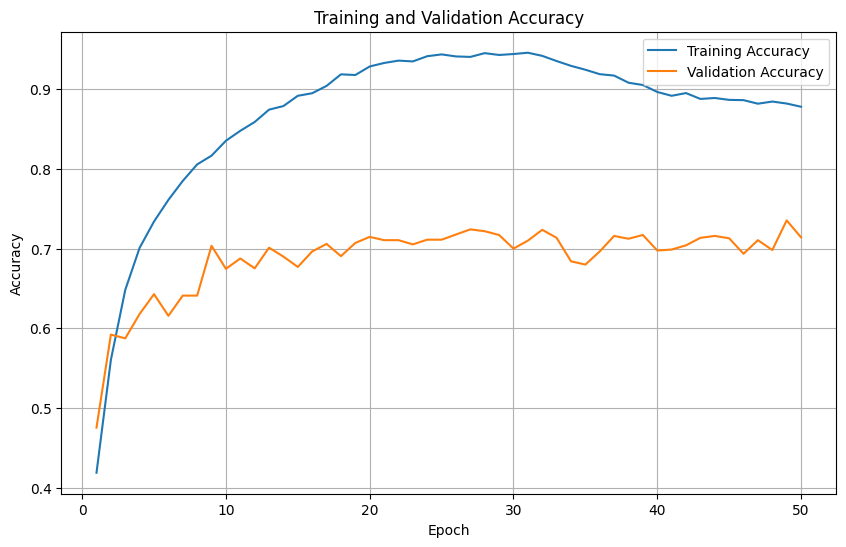

In [43]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

time to train model:   0.0 hours,   4.0 minutes,   0 seconds
Test acc: 0.679


In [45]:
torch.save(model, path_to_save+'cnn')

## shallow cnn

In [46]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [47]:
class Shallow(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.5,
                 kernel=25,
                 stride=1,
                 padding=0,
                 pool_kernel=50,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(Shallow, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 8,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 8),
            nn.AvgPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout),
            nn.Tanh()
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 4, out_features=depth * 2),
            nn.ReLU(),
        )

        self.dense = nn.Linear(in_features=depth * 2,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.nd(x)
        x = self.dense(x)

        return F.log_softmax(x, dim=1)

In [48]:
torchinfo.summary(Shallow(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
Shallow                                  [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 376]             --
│    └─Conv1d: 2-1                       [64, 25, 376]             13,775
│    └─ReLU: 2-2                         [64, 25, 376]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 376]             50
│    └─Dropout: 2-4                      [64, 25, 376]             --
├─Sequential: 1-2                        [64, 200, 1, 7]           --
│    └─Conv2d: 2-5                       [64, 200, 1, 352]         125,200
│    └─ELU: 2-6                          [64, 200, 1, 352]         --
│    └─BatchNorm2d: 2-7                  [64, 200, 1, 352]         400
│    └─AvgPool2d: 2-8                    [64, 200, 1, 7]           --
│    └─Dropout: 2-9                      [64, 200, 1, 7]           --
│    └─Tanh: 2-10                        [64, 200, 1, 7]           --
├─Seq

In [49]:
model = Shallow().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02, weight_decay=0.005, momentum=0.95)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

In [ ]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.277, Val acc: 0.273, Val loss: 1.384
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.298, Val acc: 0.302, Val loss: 1.401
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.316, Val acc: 0.277, Val loss: 1.370
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.325, Val acc: 0.268, Val loss: 1.382
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.326, Val acc: 0.319, Val loss: 1.388
Epoch 6


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.325, Val acc: 0.292, Val loss: 1.383
Epoch 7


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.331, Val acc: 0.293, Val loss: 1.450
Epoch 8


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.325, Val acc: 0.238, Val loss: 1.372
Epoch 9


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.332, Val acc: 0.294, Val loss: 1.365
Epoch 10


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.330, Val acc: 0.265, Val loss: 1.419
Epoch 11


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.322, Val acc: 0.279, Val loss: 1.381
Epoch 12


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.328, Val acc: 0.291, Val loss: 1.396
Epoch 13


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.335, Val acc: 0.271, Val loss: 1.385
Epoch 14


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.333, Val acc: 0.277, Val loss: 1.394
Epoch 15


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.337, Val acc: 0.243, Val loss: 1.461
Epoch 16


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.330, Val acc: 0.244, Val loss: 1.358
Epoch 17


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.340, Val acc: 0.279, Val loss: 1.358
Epoch 18


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.339, Val acc: 0.284, Val loss: 1.429
Epoch 19


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.338, Val acc: 0.239, Val loss: 1.421
Epoch 20


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.339, Val acc: 0.291, Val loss: 1.426
Epoch 21


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.347, Val acc: 0.270, Val loss: 1.433
Epoch 22


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.353, Val acc: 0.288, Val loss: 1.417
Epoch 23


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.351, Val acc: 0.275, Val loss: 1.424
Epoch 24


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.361, Val acc: 0.296, Val loss: 1.430
Epoch 25


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.362, Val acc: 0.292, Val loss: 1.448
Epoch 26


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.364, Val acc: 0.320, Val loss: 1.404
Epoch 27


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.325, Val loss: 1.395
Epoch 28


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.369, Val acc: 0.302, Val loss: 1.362
Epoch 29


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.375, Val acc: 0.301, Val loss: 1.433
Epoch 30


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.375, Val acc: 0.278, Val loss: 1.391
Epoch 31


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.377, Val acc: 0.292, Val loss: 1.413
Epoch 32


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.385, Val acc: 0.293, Val loss: 1.355
Epoch 33


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.388, Val acc: 0.267, Val loss: 1.411
Epoch 34


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.388, Val acc: 0.323, Val loss: 1.421
Epoch 35


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.392, Val acc: 0.271, Val loss: 1.386
Epoch 36


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.400, Val acc: 0.269, Val loss: 1.383
Epoch 37


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.276, Val loss: 1.376
Epoch 38


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.291, Val loss: 1.412
Epoch 39


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.283, Val loss: 1.403
Epoch 40


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.285, Val loss: 1.409
Epoch 41


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.430, Val acc: 0.302, Val loss: 1.348
Epoch 42


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.325, Val loss: 1.473
Epoch 43


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.440, Val acc: 0.312, Val loss: 1.520
Epoch 44


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.455, Val acc: 0.316, Val loss: 1.388
Epoch 45


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.454, Val acc: 0.327, Val loss: 1.433
Epoch 46


  0%|          | 0/238 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

In [ ]:
torch.save(model, path_to_save+'shallow_cnn')

## cnn lstm

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 num_layers=2,
                 dropout=0.5,
                 kernel=3,
                 stride=2,
                 padding=0,
                 pool_kernel=2,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.linear = nn.Sequential(
            nn.Linear(in_features=depth * 8,
                      out_features=depth * 8),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
        )

        self.lstm1 = nn.LSTM(input_size=depth * 4,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.lstm2 = nn.LSTM(input_size=depth * 8,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            # TimeDistributed(nn.Dropout(dropout)),
            # TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            # TimeDistributed(nn.ReLU()),
            # TimeDistributed(nn.BatchNorm1d(depth * 2)),
            # TimeDistributed(nn.Dropout(dropout)),
        )

        self.dense = nn.Linear(in_features=depth * 4, out_features=num_classes)

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            # nn.Linear(in_features=depth * 4, out_features=depth * 2),
            # nn.ReLU(),
            # nn.BatchNorm1d(depth * 2),
            # nn.Dropout(dropout),
            # nn.Linear(in_features=depth * 2, out_features=depth),
            # nn.ReLU(),
            # nn.BatchNorm1d(depth),
            # nn.Dropout(dropout),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.linear(x)
        x, _ = self.lstm1(x)
        #x, _ = self.lstm2(x)
        #x = self.td(x)
        x = self.nd(x)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [ ]:
torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

In [ ]:
model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=0.0001)

In [ ]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

In [ ]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

In [ ]:
torch.save(model, path_to_save+'cnn_lstm')

## cnn gru

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [ ]:
class GRU(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=128,
                 num_layers=2,
                 dropout=0.5,
                 kernel=7,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=64):
        super(GRU, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 1),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
        )

        self.gru = nn.GRU(input_size=depth * 4,
                           hidden_size=depth * 4,
                           num_layers=num_layers,
                           bias=True,
                           batch_first=True,
                           bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 2)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 2, out_features=depth)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth)),
            TimeDistributed(nn.Dropout(dropout)),
        )
        self.dense = nn.Linear(in_features=depth * 8, out_features=num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.nd(x)
        x, _ = self.gru(x)
        #x = self.td(x)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [ ]:
torchinfo.summary(GRU(), input_size=(batch_size, 22, 400))

In [ ]:
model = GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

In [ ]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

In [ ]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

In [ ]:
torch.save(model, path_to_save+'cnn_gru')

## lstm-lstm

In [ ]:
class LSTM_LSTM(nn.Module):
    def __init__(self,
                 input_size = 22,
                 hidden_size = 64,
                 num_layers = 2,
                 output_size = 54,
                 num_classes = 4):
        super(LSTM_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True,
                             bidirectional=True)

        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size * 2,
                             hidden_size,
                             num_layers,
                             batch_first=True,
                             bidirectional=True)


        # Output layer
        self.linear = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Sequential(
            nn.Linear(output_size, output_size-10),
            nn.BatchNorm1d(num_features=output_size-10, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(output_size-10, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)

        # Forward pass through LSTM1
        out, _ = self.lstm1(x)

        # Forward pass through LSTM2
        out, _ = self.lstm2(out)

        # fc layer
        out = self.linear(out[:, -1, :])
        return out


In [ ]:
torchinfo.summary(LSTM_LSTM(), input_size=(batch_size, 22, 400))

In [ ]:
model = LSTM_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

In [ ]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

In [ ]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

In [ ]:
torch.save(model, path_to_save+'lstm_lstm')

## gru

In [ ]:
class GRU(nn.Module):
    def __init__(self,
                 input_size = 22,
                 hidden_size = 64,
                 num_layers = 3,
                 output_size = 54,
                 num_classes = 4):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU Layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=True)

        # Output layer
        self.linear = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Sequential(
            nn.Linear(output_size, output_size-10),
            nn.BatchNorm1d(num_features=output_size-10, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(output_size-10, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)

        # Forward pass through GRU
        out, _ = self.gru(x)

        # fc layer
        out = self.linear(out[:, -1, :])
        return out


In [ ]:
torchinfo.summary(GRU(), input_size=(batch_size, 22, 400))

In [ ]:
model = GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

In [ ]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

In [ ]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

In [ ]:
torch.save(model, path_to_save+'gru')

# end

In [ ]:
print('time i will never get back:')
hours = (end_time - super_start_time) // 3600
minutes = ((end_time - super_start_time) % 3600) // 60
seconds = (end_time - super_start_time) % 60

print(f'time to train models: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

# GOOD CNN

In [ ]:
# batch size 64
# channel dropout 0.01
# noise True
# smooth_time_mask 0

In [12]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout, kernel1, kernel2, kernel3, kernel4, pool_kernel):
        super(CNN, self).__init__()

        self.time_bins = 400
        self.magic_number = self.time_bins + kernel3 - 1

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=22, out_channels=25, kernel_size=kernel1),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(dropout)
        )

        self.L_pool = self.time_bins - kernel1 + 1

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=kernel2),
            nn.ELU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel2[1] + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=100, kernel_size=kernel3),
            nn.ELU(),
            nn.BatchNorm1d(100),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel3 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=self.magic_number, kernel_size=kernel4),
            nn.ELU(),
            nn.BatchNorm1d(self.magic_number),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel4 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.dense = nn.Linear(in_features= self.L_pool * self.magic_number, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)      # match dims for Conv2d().
        x = self.conv2(x)
        x = x.squeeze(2)        # match dims for Conv1d().
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1) # match dims for affine.
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [20]:
from torchinfo import summary

model = CNN(num_classes=4,
          dropout=0.3647999634687216,
          kernel1=5,
          kernel2=(1, 25),
          kernel3=6,
          kernel4=5,
          pool_kernel=3).to(device)
summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [25]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.468, Val acc: 0.607, Val loss: 1.023
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.647, Val acc: 0.687, Val loss: 0.749
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.721, Val loss: 0.639
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.798, Val acc: 0.721, Val loss: 0.558
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.841, Val acc: 0.736, Val loss: 0.531
Epoch 6


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.862, Val acc: 0.768, Val loss: 0.667
Epoch 7


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.764, Val loss: 0.536
Epoch 8


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.892, Val acc: 0.761, Val loss: 0.684
Epoch 9


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.901, Val acc: 0.774, Val loss: 0.536
Epoch 10


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.906, Val acc: 0.757, Val loss: 0.511
Epoch 11


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.782, Val loss: 0.478
Epoch 12


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.768, Val loss: 0.680
Epoch 13


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.922, Val acc: 0.746, Val loss: 0.613
Epoch 14


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.924, Val acc: 0.742, Val loss: 0.593
Epoch 15


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.751, Val loss: 0.589
Epoch 16


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.758, Val loss: 0.617
Epoch 17


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.729, Val loss: 0.731
Epoch 18


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.758, Val loss: 0.700
Epoch 19


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.758, Val loss: 0.472
Epoch 20


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.752, Val loss: 0.633
Epoch 21


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.770, Val loss: 0.623
Epoch 22


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.775, Val loss: 0.610
Epoch 23


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.947, Val acc: 0.752, Val loss: 0.561
Epoch 24


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.719, Val loss: 0.612
Epoch 25


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.767, Val loss: 0.503
Epoch 26


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.770, Val loss: 0.612
Epoch 27


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.753, Val loss: 0.550
Epoch 28


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.761, Val loss: 0.621
Epoch 29


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.943, Val acc: 0.763, Val loss: 0.705
Epoch 30


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.772, Val loss: 0.501
Epoch 31


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.798, Val loss: 0.553
Epoch 32


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.803, Val loss: 0.564
Epoch 33


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.801, Val loss: 0.587
Epoch 34


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.798, Val loss: 0.546
Epoch 35


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.801, Val loss: 0.553
Epoch 36


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.804, Val loss: 0.550
Epoch 37


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.801, Val loss: 0.549
Epoch 38


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.807, Val loss: 0.582
Epoch 39


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.802, Val loss: 0.582
Epoch 40


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.807, Val loss: 0.547
Epoch 41


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.794, Val loss: 0.581
Epoch 42


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.800, Val loss: 0.560
Epoch 43


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.804, Val loss: 0.566
Epoch 44


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.803, Val loss: 0.568
Epoch 45


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.802, Val loss: 0.569
Epoch 46


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.802, Val loss: 0.575
Epoch 47


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.804, Val loss: 0.564
Epoch 48


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.807, Val loss: 0.563
Epoch 49


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.558
Epoch 50


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.804, Val loss: 0.555
Epoch 51


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.561
Epoch 52


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.807, Val loss: 0.561
Epoch 53


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.558
Epoch 54


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.557
Epoch 55


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.562
Epoch 56


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.812, Val loss: 0.564
Epoch 57


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.807, Val loss: 0.562
Epoch 58


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.561
Epoch 59


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.805, Val loss: 0.559
Epoch 60


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.807, Val loss: 0.560
Epoch 61


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.805, Val loss: 0.561
Epoch 62


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.808, Val loss: 0.562
Epoch 63


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.807, Val loss: 0.560
Epoch 64


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.811, Val loss: 0.562
Epoch 65


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.566
Epoch 66


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.561
Epoch 67


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.566
Epoch 68


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.805, Val loss: 0.561
Epoch 69


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.809, Val loss: 0.563
Epoch 70


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.807, Val loss: 0.563
Epoch 71


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.810, Val loss: 0.563
Epoch 72


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.811, Val loss: 0.565
Epoch 73


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.809, Val loss: 0.561
Epoch 74


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.808, Val loss: 0.560
Epoch 75


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.808, Val loss: 0.566
Epoch 76


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.810, Val loss: 0.563
Epoch 77


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.553
Epoch 78


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.808, Val loss: 0.563
Epoch 79


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.811, Val loss: 0.565
Epoch 80


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.805, Val loss: 0.558
Epoch 81


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.553
Epoch 82


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.811, Val loss: 0.562
Epoch 83


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.568
Epoch 84


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.810, Val loss: 0.562
Epoch 85


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.808, Val loss: 0.561
Epoch 86


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.558
Epoch 87


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.808, Val loss: 0.564
Epoch 88


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.814, Val loss: 0.567
Epoch 89


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.810, Val loss: 0.560
Epoch 90


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.812, Val loss: 0.564
Epoch 91


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.811, Val loss: 0.570
Epoch 92


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.809, Val loss: 0.559
Epoch 93


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.804, Val loss: 0.566
Epoch 94


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.811, Val loss: 0.563
Epoch 95


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.811, Val loss: 0.558
Epoch 96


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.810, Val loss: 0.563
Epoch 97


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.812, Val loss: 0.564
Epoch 98


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.806, Val loss: 0.559
Epoch 99


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.806, Val loss: 0.556
Epoch 100


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.808, Val loss: 0.562


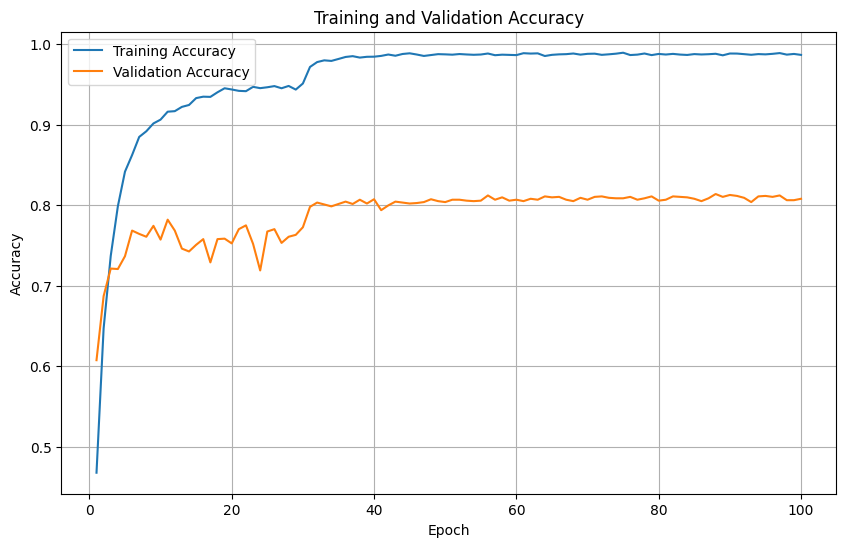

In [26]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
test_model(model, test_loader)

Test acc: 0.743


In [28]:
torch.save(model, './hopefully_better/cnn')

# other cnn trying to seed

In [17]:
number_epochs = 100

In [8]:
# batch size 64
# channel dropout 0
# noise False
# smooth_time_mask False

In [19]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout, kernel1, kernel2, kernel3, kernel4, pool_kernel):
        super(CNN, self).__init__()

        self.time_bins = 400
        self.magic_number = self.time_bins + kernel3 - 1

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=22, out_channels=25, kernel_size=kernel1),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(dropout)
        )

        self.L_pool = self.time_bins - kernel1 + 1

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=kernel2),
            nn.ELU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel2[1] + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=100, kernel_size=kernel3),
            nn.ELU(),
            nn.BatchNorm1d(100),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel3 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=self.magic_number, kernel_size=kernel4),
            nn.ELU(),
            nn.BatchNorm1d(self.magic_number),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel4 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.dense = nn.Linear(in_features= self.L_pool * self.magic_number, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)      # match dims for Conv2d().
        x = self.conv2(x)
        x = x.squeeze(2)        # match dims for Conv1d().
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1) # match dims for affine.
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [20]:
from torchinfo import summary

model = CNN(num_classes=4,
          dropout=0.3647999634687216,
          kernel1=5,
          kernel2=(1, 25),
          kernel3=6,
          kernel4=5,
          pool_kernel=3).to(device)
summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [22]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.398, Val acc: 0.402, Val loss: 1.456
Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.554, Val acc: 0.495, Val loss: 1.270
Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.630, Val acc: 0.540, Val loss: 1.374
Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.561, Val loss: 1.260
Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.724, Val acc: 0.585, Val loss: 1.113
Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.771, Val acc: 0.645, Val loss: 0.902
Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.798, Val acc: 0.604, Val loss: 0.935
Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.816, Val acc: 0.654, Val loss: 0.782
Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.625, Val loss: 0.836
Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.659, Val loss: 0.719
Epoch 11


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.616, Val loss: 0.889
Epoch 12


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.631, Val loss: 0.948
Epoch 13


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.651, Val loss: 0.650
Epoch 14


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.894, Val acc: 0.632, Val loss: 0.747
Epoch 15


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.900, Val acc: 0.636, Val loss: 0.911
Epoch 16


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.700, Val loss: 0.680
Epoch 17


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.640, Val loss: 0.768
Epoch 18


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.651, Val loss: 0.723
Epoch 19


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.921, Val acc: 0.680, Val loss: 0.777
Epoch 20


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.647, Val loss: 0.705
Epoch 21


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.924, Val acc: 0.639, Val loss: 0.918
Epoch 22


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.932, Val acc: 0.691, Val loss: 0.854
Epoch 23


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.930, Val acc: 0.671, Val loss: 0.791
Epoch 24


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.654, Val loss: 0.911
Epoch 25


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.660, Val loss: 0.816
Epoch 26


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.682, Val loss: 0.772
Epoch 27


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.669, Val loss: 0.755
Epoch 28


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.669, Val loss: 0.793
Epoch 29


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.663, Val loss: 0.854
Epoch 30


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.669, Val loss: 0.822
Epoch 31


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.670, Val loss: 0.813
Epoch 32


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.975, Val acc: 0.658, Val loss: 0.825
Epoch 33


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.670, Val loss: 0.857
Epoch 34


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.975, Val acc: 0.672, Val loss: 0.890
Epoch 35


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.975, Val acc: 0.665, Val loss: 0.873
Epoch 36


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.671, Val loss: 0.836
Epoch 37


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.670, Val loss: 0.838
Epoch 38


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.975, Val acc: 0.672, Val loss: 0.851
Epoch 39


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.669, Val loss: 0.840
Epoch 40


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.675, Val loss: 0.850
Epoch 41


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.676, Val loss: 0.852
Epoch 42


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.676, Val loss: 0.873
Epoch 43


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.680, Val loss: 0.877
Epoch 44


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.679, Val loss: 0.881
Epoch 45


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.678, Val loss: 0.872
Epoch 46


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.678, Val loss: 0.874
Epoch 47


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.685, Val loss: 0.857
Epoch 48


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.678, Val loss: 0.876
Epoch 49


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.678, Val loss: 0.875
Epoch 50


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.682, Val loss: 0.856
Epoch 51


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.682, Val loss: 0.859
Epoch 52


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.680, Val loss: 0.868
Epoch 53


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.683, Val loss: 0.866
Epoch 54


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.684, Val loss: 0.861
Epoch 55


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.678, Val loss: 0.876
Epoch 56


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.679, Val loss: 0.873
Epoch 57


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.682, Val loss: 0.868
Epoch 58


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.678, Val loss: 0.878
Epoch 59


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.683, Val loss: 0.862
Epoch 60


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.679, Val loss: 0.878
Epoch 61


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.688, Val loss: 0.860
Epoch 62


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.683, Val loss: 0.858
Epoch 63


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.680, Val loss: 0.867
Epoch 64


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.682, Val loss: 0.863
Epoch 65


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.676, Val loss: 0.877
Epoch 66


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.676, Val loss: 0.864
Epoch 67


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.678, Val loss: 0.875
Epoch 68


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.677, Val loss: 0.863
Epoch 69


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.685, Val loss: 0.866
Epoch 70


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.680, Val loss: 0.878
Epoch 71


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.684, Val loss: 0.850
Epoch 72


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.682, Val loss: 0.870
Epoch 73


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.682, Val loss: 0.859
Epoch 74


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.680, Val loss: 0.871
Epoch 75


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.673, Val loss: 0.882
Epoch 76


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.682, Val loss: 0.863
Epoch 77


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.684, Val loss: 0.857
Epoch 78


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.680, Val loss: 0.864
Epoch 79


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.680, Val loss: 0.862
Epoch 80


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.686, Val loss: 0.864
Epoch 81


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.680, Val loss: 0.864
Epoch 82


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.682, Val loss: 0.861
Epoch 83


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.682, Val loss: 0.867
Epoch 84


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.682, Val loss: 0.863
Epoch 85


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.680, Val loss: 0.868
Epoch 86


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.676, Val loss: 0.870
Epoch 87


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.680, Val loss: 0.865
Epoch 88


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.679, Val loss: 0.866
Epoch 89


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.678, Val loss: 0.869
Epoch 90


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.679, Val loss: 0.864
Epoch 91


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.675, Val loss: 0.878
Epoch 92


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.684, Val loss: 0.866
Epoch 93


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.680, Val loss: 0.867
Epoch 94


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.676, Val loss: 0.868
Epoch 95


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.680, Val loss: 0.869
Epoch 96


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.673, Val loss: 0.873
Epoch 97


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.684, Val loss: 0.853
Epoch 98


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.682, Val loss: 0.867
Epoch 99


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.672, Val loss: 0.873
Epoch 100


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.975, Val acc: 0.683, Val loss: 0.863


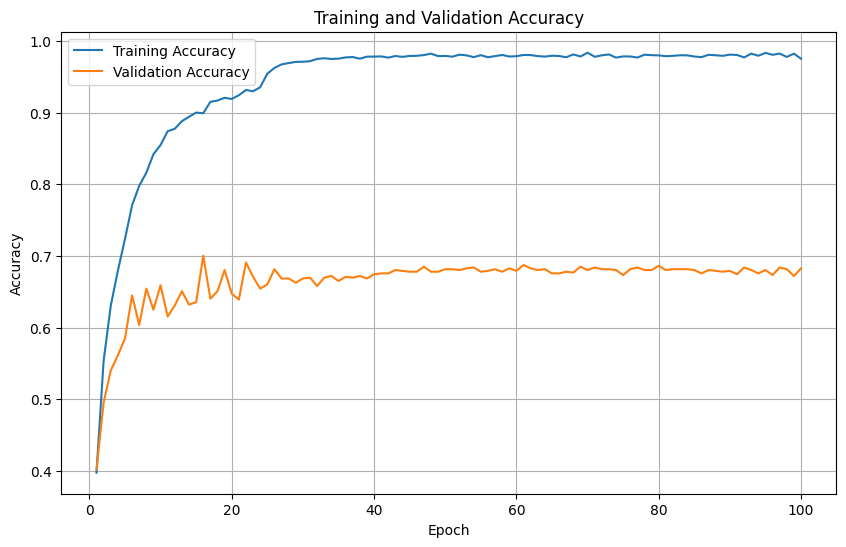

In [23]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
test_model(model, test_loader)

Test acc: 0.734


In [25]:
torch.save(model, './hopefully_better/cnn-other')

# cnn seeded with augments

In [9]:
number_epochs = 100

In [10]:
# batch size 64
# channel dropout 0.01
# noise True
# smooth_time_mask True

In [11]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout, kernel1, kernel2, kernel3, kernel4, pool_kernel):
        super(CNN, self).__init__()

        self.time_bins = 400
        self.magic_number = self.time_bins + kernel3 - 1

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=22, out_channels=25, kernel_size=kernel1),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(dropout)
        )

        self.L_pool = self.time_bins - kernel1 + 1

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=kernel2),
            nn.ELU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel2[1] + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=100, kernel_size=kernel3),
            nn.ELU(),
            nn.BatchNorm1d(100),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel3 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=self.magic_number, kernel_size=kernel4),
            nn.ELU(),
            nn.BatchNorm1d(self.magic_number),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel4 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.dense = nn.Linear(in_features= self.L_pool * self.magic_number, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)      # match dims for Conv2d().
        x = self.conv2(x)
        x = x.squeeze(2)        # match dims for Conv1d().
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1) # match dims for affine.
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [12]:
from torchinfo import summary

model = CNN(num_classes=4,
          dropout=0.3647999634687216,
          kernel1=5,
          kernel2=(1, 25),
          kernel3=6,
          kernel4=5,
          pool_kernel=3).to(device)
summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.0001, last_epoch=100)

In [14]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.511, Val acc: 0.501, Val loss: 1.221
Epoch 2


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.698, Val acc: 0.626, Val loss: 1.057
Epoch 3


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.765, Val acc: 0.637, Val loss: 0.920
Epoch 4


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.806, Val acc: 0.665, Val loss: 0.872
Epoch 5


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.828, Val acc: 0.643, Val loss: 0.927
Epoch 6


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.655, Val loss: 0.871
Epoch 7


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.701, Val loss: 0.864
Epoch 8


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.686, Val loss: 0.877
Epoch 9


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.699, Val loss: 0.823
Epoch 10


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.688, Val loss: 0.827
Epoch 11


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.886, Val acc: 0.697, Val loss: 0.831
Epoch 12


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.891, Val acc: 0.672, Val loss: 0.870
Epoch 13


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.891, Val acc: 0.708, Val loss: 0.788
Epoch 14


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.710, Val loss: 0.784
Epoch 15


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.896, Val acc: 0.705, Val loss: 0.834
Epoch 16


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.896, Val acc: 0.717, Val loss: 0.838
Epoch 17


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.686, Val loss: 0.926
Epoch 18


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.901, Val acc: 0.685, Val loss: 0.878
Epoch 19


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.679, Val loss: 0.988
Epoch 20


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.902, Val acc: 0.683, Val loss: 0.849
Epoch 21


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.699, Val loss: 0.842
Epoch 22


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.904, Val acc: 0.685, Val loss: 0.970
Epoch 23


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.904, Val acc: 0.721, Val loss: 0.818
Epoch 24


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.711, Val loss: 0.872
Epoch 25


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.905, Val acc: 0.723, Val loss: 0.820
Epoch 26


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.723, Val loss: 0.800
Epoch 27


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.726, Val loss: 0.818
Epoch 28


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.731, Val loss: 0.817
Epoch 29


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.731, Val loss: 0.830
Epoch 30


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.729, Val loss: 0.791
Epoch 31


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.718, Val loss: 0.807
Epoch 32


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.735, Val loss: 0.839
Epoch 33


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.725, Val loss: 0.837
Epoch 34


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.721, Val loss: 0.822
Epoch 35


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.719, Val loss: 0.823
Epoch 36


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.723, Val loss: 0.776
Epoch 37


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.716, Val loss: 0.836
Epoch 38


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.732, Val loss: 0.775
Epoch 39


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.725, Val loss: 0.805
Epoch 40


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.725, Val loss: 0.785
Epoch 41


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.723, Val loss: 0.805
Epoch 42


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.730, Val loss: 0.800
Epoch 43


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.723, Val loss: 0.796
Epoch 44


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.726, Val loss: 0.809
Epoch 45


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.721, Val loss: 0.787
Epoch 46


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.726, Val loss: 0.804
Epoch 47


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.727, Val loss: 0.785
Epoch 48


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.734, Val loss: 0.776
Epoch 49


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.964, Val acc: 0.728, Val loss: 0.770
Epoch 50


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.719, Val loss: 0.796
Epoch 51


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.964, Val acc: 0.730, Val loss: 0.732
Epoch 52


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.728, Val loss: 0.796
Epoch 53


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.728, Val loss: 0.777
Epoch 54


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.715, Val loss: 0.787
Epoch 55


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.716, Val loss: 0.859
Epoch 56


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.725, Val loss: 0.806
Epoch 57


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.728, Val loss: 0.770
Epoch 58


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.722, Val loss: 0.784
Epoch 59


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.964, Val acc: 0.721, Val loss: 0.827
Epoch 60


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.964, Val acc: 0.719, Val loss: 0.761
Epoch 61


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.711, Val loss: 0.733
Epoch 62


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.716, Val loss: 0.803
Epoch 63


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.716, Val loss: 0.774
Epoch 64


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.726, Val loss: 0.753
Epoch 65


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.708, Val loss: 0.766
Epoch 66


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.718, Val loss: 0.776
Epoch 67


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.725, Val loss: 0.750
Epoch 68


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.721, Val loss: 0.766
Epoch 69


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.717, Val loss: 0.764
Epoch 70


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.721, Val loss: 0.766
Epoch 71


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.723, Val loss: 0.763
Epoch 72


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.718, Val loss: 0.780
Epoch 73


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.729, Val loss: 0.749
Epoch 74


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.724, Val loss: 0.758
Epoch 75


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.723, Val loss: 0.764
Epoch 76


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.723, Val loss: 0.769
Epoch 77


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.725, Val loss: 0.764
Epoch 78


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.729, Val loss: 0.748
Epoch 79


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.726, Val loss: 0.755
Epoch 80


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.721, Val loss: 0.772
Epoch 81


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.719, Val loss: 0.770
Epoch 82


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.723, Val loss: 0.762
Epoch 83


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.719, Val loss: 0.772
Epoch 84


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.720, Val loss: 0.770
Epoch 85


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.723, Val loss: 0.772
Epoch 86


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.723, Val loss: 0.759
Epoch 87


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.722, Val loss: 0.769
Epoch 88


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.728, Val loss: 0.754
Epoch 89


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.724, Val loss: 0.767
Epoch 90


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.728, Val loss: 0.751
Epoch 91


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.723, Val loss: 0.766
Epoch 92


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.725, Val loss: 0.763
Epoch 93


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.725, Val loss: 0.760
Epoch 94


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.724, Val loss: 0.770
Epoch 95


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.722, Val loss: 0.768
Epoch 96


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.716, Val loss: 0.781
Epoch 97


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.722, Val loss: 0.768
Epoch 98


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.723, Val loss: 0.769
Epoch 99


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.721, Val loss: 0.770
Epoch 100


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.723, Val loss: 0.768


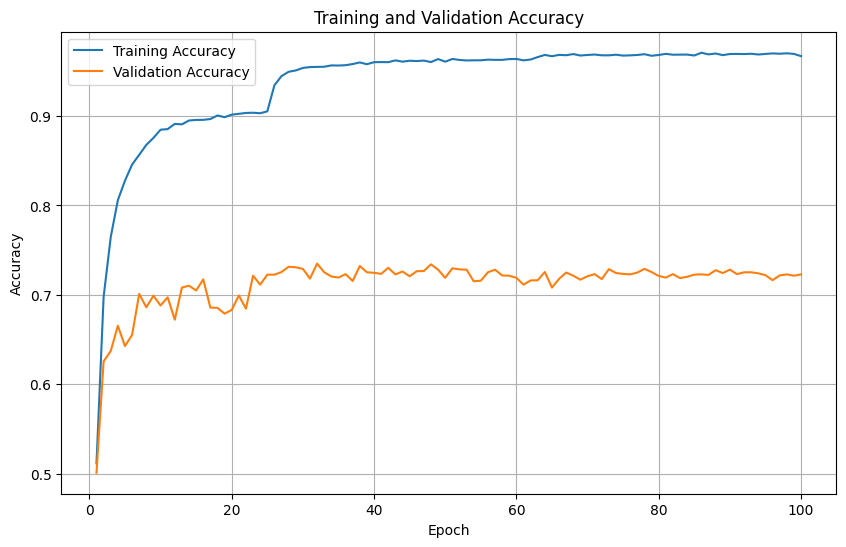

In [15]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
test_model(model, test_loader)

Test acc: 0.738


In [17]:
torch.save(model, './hopefully_better/cnn-seeded-augmented-other')

In [ ]:
# cnn with seed, augments, and cosine

# cnn seeded with augments cosine

In [20]:
number_epochs = 50

In [21]:
# batch size 64
# channel dropout 0.01
# noise True
# smooth_time_mask True

In [22]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout, kernel1, kernel2, kernel3, kernel4, pool_kernel):
        super(CNN, self).__init__()

        self.time_bins = 400
        self.magic_number = self.time_bins + kernel3 - 1

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=22, out_channels=25, kernel_size=kernel1),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(dropout)
        )

        self.L_pool = self.time_bins - kernel1 + 1

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=kernel2),
            nn.ELU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel2[1] + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=100, kernel_size=kernel3),
            nn.ELU(),
            nn.BatchNorm1d(100),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel3 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=self.magic_number, kernel_size=kernel4),
            nn.ELU(),
            nn.BatchNorm1d(self.magic_number),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel4 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.dense = nn.Linear(in_features= self.L_pool * self.magic_number, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)      # match dims for Conv2d().
        x = self.conv2(x)
        x = x.squeeze(2)        # match dims for Conv1d().
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1) # match dims for affine.
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [23]:
from torchinfo import summary

model = CNN(num_classes=4,
          dropout=0.3647999634687216,
          kernel1=5,
          kernel2=(1, 25),
          kernel3=6,
          kernel4=5,
          pool_kernel=3).to(device)
summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.0001)

In [27]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.507, Val acc: 0.522, Val loss: 1.078
Epoch 2


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.689, Val acc: 0.594, Val loss: 1.145
Epoch 3


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.761, Val acc: 0.646, Val loss: 0.921
Epoch 4


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.802, Val acc: 0.656, Val loss: 0.902
Epoch 5


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.828, Val acc: 0.647, Val loss: 0.959
Epoch 6


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.658, Val loss: 0.947
Epoch 7


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.669, Val loss: 0.816
Epoch 8


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.669, Val loss: 0.985
Epoch 9


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.884, Val acc: 0.655, Val loss: 1.012
Epoch 10


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.675, Val loss: 0.915
Epoch 11


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.904, Val acc: 0.670, Val loss: 0.876
Epoch 12


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.907, Val acc: 0.661, Val loss: 0.849
Epoch 13


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.680, Val loss: 0.861
Epoch 14


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.923, Val acc: 0.675, Val loss: 0.792
Epoch 15


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.927, Val acc: 0.688, Val loss: 0.816
Epoch 16


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.686, Val loss: 0.858
Epoch 17


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.936, Val acc: 0.695, Val loss: 0.802
Epoch 18


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.690, Val loss: 0.858
Epoch 19


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.695, Val loss: 0.783
Epoch 20


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.681, Val loss: 0.838
Epoch 21


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.687, Val loss: 0.782
Epoch 22


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.695, Val loss: 0.799
Epoch 23


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.687, Val loss: 0.828
Epoch 24


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.683, Val loss: 0.806
Epoch 25


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.700, Val loss: 0.828
Epoch 26


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.690, Val loss: 0.841
Epoch 27


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.692, Val loss: 0.777
Epoch 28


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.701, Val loss: 0.796
Epoch 29


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.699, Val loss: 0.794
Epoch 30


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.680, Val loss: 0.797
Epoch 31


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.688, Val loss: 0.819
Epoch 32


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.685, Val loss: 0.818
Epoch 33


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.701, Val loss: 0.769
Epoch 34


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.690, Val loss: 0.800
Epoch 35


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.701, Val loss: 0.854
Epoch 36


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.938, Val acc: 0.689, Val loss: 0.872
Epoch 37


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.936, Val acc: 0.690, Val loss: 0.836
Epoch 38


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.930, Val acc: 0.698, Val loss: 0.780
Epoch 39


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.926, Val acc: 0.687, Val loss: 0.900
Epoch 40


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.681, Val loss: 0.972
Epoch 41


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.686, Val loss: 0.941
Epoch 42


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.703, Val loss: 0.846
Epoch 43


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.705, Val loss: 0.815
Epoch 44


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.679, Val loss: 0.949
Epoch 45


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.907, Val acc: 0.682, Val loss: 0.862
Epoch 46


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.904, Val acc: 0.667, Val loss: 0.980
Epoch 47


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.911, Val acc: 0.667, Val loss: 0.919
Epoch 48


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.906, Val acc: 0.701, Val loss: 0.799
Epoch 49


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.905, Val acc: 0.696, Val loss: 0.806
Epoch 50


  0%|          | 0/476 [00:00<?, ?it/s]

Train acc: 0.904, Val acc: 0.667, Val loss: 0.932


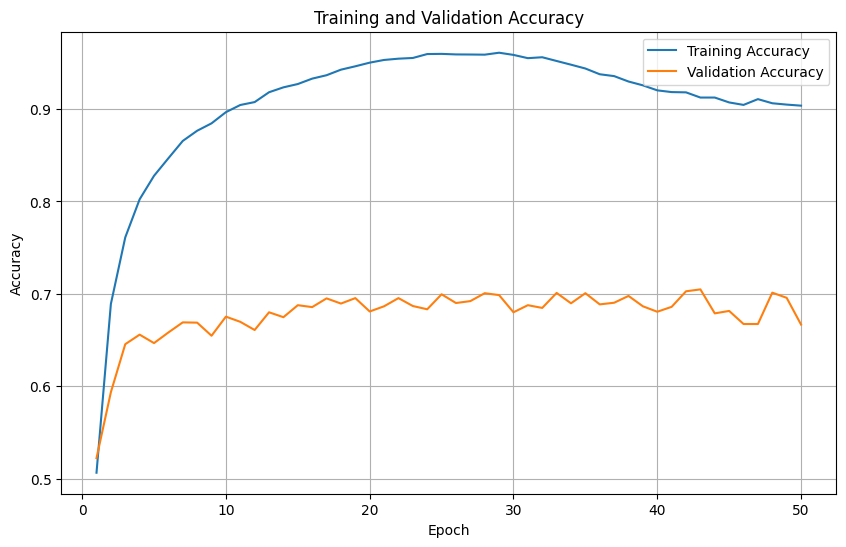

In [28]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
test_model(model, test_loader)

Test acc: 0.722


In [30]:
torch.save(model, './hopefully_better/cnn-seeded-augmented-cosine')

# cnn seeded with no augments cosine

In [18]:
number_epochs = 100

In [19]:
# batch size 64
# channel dropout 0.01
# noise True
# smooth_time_mask True

In [20]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout, kernel1, kernel2, kernel3, kernel4, pool_kernel):
        super(CNN, self).__init__()

        self.time_bins = 400
        self.magic_number = self.time_bins + kernel3 - 1

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=22, out_channels=25, kernel_size=kernel1),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(dropout)
        )

        self.L_pool = self.time_bins - kernel1 + 1

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=kernel2),
            nn.ELU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel2[1] + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=100, kernel_size=kernel3),
            nn.ELU(),
            nn.BatchNorm1d(100),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel3 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=self.magic_number, kernel_size=kernel4),
            nn.ELU(),
            nn.BatchNorm1d(self.magic_number),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel4 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.dense = nn.Linear(in_features= self.L_pool * self.magic_number, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)      # match dims for Conv2d().
        x = self.conv2(x)
        x = x.squeeze(2)        # match dims for Conv1d().
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1) # match dims for affine.
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [21]:
from torchinfo import summary

model = CNN(num_classes=4,
          dropout=0.3647999634687216,
          kernel1=5,
          kernel2=(1, 25),
          kernel3=6,
          kernel4=5,
          pool_kernel=3).to(device)
summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.0001)

In [23]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.416, Val acc: 0.452, Val loss: 1.022
Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.564, Val acc: 0.565, Val loss: 0.841
Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.636, Val acc: 0.578, Val loss: 0.540
Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.693, Val acc: 0.608, Val loss: 0.566
Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.728, Val acc: 0.642, Val loss: 0.493
Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.765, Val acc: 0.660, Val loss: 0.519
Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.794, Val acc: 0.683, Val loss: 0.563
Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.818, Val acc: 0.658, Val loss: 0.765
Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.834, Val acc: 0.684, Val loss: 0.520
Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.718, Val loss: 0.515
Epoch 11


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.688, Val loss: 0.627
Epoch 12


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.889, Val acc: 0.700, Val loss: 0.543
Epoch 13


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.893, Val acc: 0.710, Val loss: 0.477
Epoch 14


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.906, Val acc: 0.699, Val loss: 0.648
Epoch 15


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.706, Val loss: 0.719
Epoch 16


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.921, Val acc: 0.691, Val loss: 0.758
Epoch 17


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.704, Val loss: 0.713
Epoch 18


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.709, Val loss: 0.694
Epoch 19


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.938, Val acc: 0.688, Val loss: 0.745
Epoch 20


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.686, Val loss: 0.779
Epoch 21


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.695, Val loss: 0.719
Epoch 22


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.672, Val loss: 0.750
Epoch 23


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.690, Val loss: 0.702
Epoch 24


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.693, Val loss: 0.763
Epoch 25


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.690, Val loss: 0.740
Epoch 26


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.689, Val loss: 0.721
Epoch 27


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.683, Val loss: 0.770
Epoch 28


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.692, Val loss: 0.795
Epoch 29


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.692, Val loss: 0.798
Epoch 30


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.715, Val loss: 0.831
Epoch 31


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.711, Val loss: 0.756
Epoch 32


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.698, Val loss: 0.831
Epoch 33


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.705, Val loss: 0.794
Epoch 34


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.710, Val loss: 0.874
Epoch 35


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.698, Val loss: 0.760
Epoch 36


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.698, Val loss: 0.849
Epoch 37


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.709, Val loss: 0.674
Epoch 38


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.947, Val acc: 0.698, Val loss: 0.868
Epoch 39


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.706, Val loss: 0.690
Epoch 40


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.938, Val acc: 0.708, Val loss: 0.780
Epoch 41


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.943, Val acc: 0.723, Val loss: 0.964
Epoch 42


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.938, Val acc: 0.688, Val loss: 0.732
Epoch 43


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.717, Val loss: 0.608
Epoch 44


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.936, Val acc: 0.709, Val loss: 0.821
Epoch 45


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.931, Val acc: 0.685, Val loss: 0.960
Epoch 46


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.686, Val loss: 0.810
Epoch 47


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.937, Val acc: 0.728, Val loss: 0.756
Epoch 48


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.936, Val acc: 0.663, Val loss: 0.800
Epoch 49


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.938, Val acc: 0.704, Val loss: 0.868
Epoch 50


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.683, Val loss: 0.896
Epoch 51


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.690, Val loss: 0.841
Epoch 52


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.690, Val loss: 0.825
Epoch 53


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.658, Val loss: 1.055
Epoch 54


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.703, Val loss: 0.690
Epoch 55


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.672, Val loss: 0.744
Epoch 56


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.680, Val loss: 0.654
Epoch 57


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.717, Val loss: 0.832
Epoch 58


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.715, Val loss: 0.586
Epoch 59


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.722, Val loss: 0.660
Epoch 60


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.704, Val loss: 0.847
Epoch 61


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.715, Val loss: 0.690
Epoch 62


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.729, Val loss: 0.684
Epoch 63


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.741, Val loss: 0.636
Epoch 64


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.739, Val loss: 0.543
Epoch 65


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.703, Val loss: 0.694
Epoch 66


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.721, Val loss: 0.741
Epoch 67


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.749, Val loss: 0.592
Epoch 68


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.718, Val loss: 0.761
Epoch 69


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.742, Val loss: 0.582
Epoch 70


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.733, Val loss: 0.602
Epoch 71


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.732, Val loss: 0.634
Epoch 72


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.715, Val loss: 0.718
Epoch 73


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.990, Val acc: 0.725, Val loss: 0.658
Epoch 74


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.722, Val loss: 0.713
Epoch 75


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.730, Val loss: 0.698
Epoch 76


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.990, Val acc: 0.721, Val loss: 0.746
Epoch 77


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.733, Val loss: 0.730
Epoch 78


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.735, Val loss: 0.672
Epoch 79


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.735, Val loss: 0.687
Epoch 80


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.725, Val loss: 0.694
Epoch 81


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.722, Val loss: 0.701
Epoch 82


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.730, Val loss: 0.636
Epoch 83


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.728, Val loss: 0.646
Epoch 84


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.724, Val loss: 0.681
Epoch 85


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.733, Val loss: 0.661
Epoch 86


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.728, Val loss: 0.639
Epoch 87


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.724, Val loss: 0.573
Epoch 88


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.749, Val loss: 0.532
Epoch 89


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.709, Val loss: 0.729
Epoch 90


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.685, Val loss: 0.519
Epoch 91


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.732, Val loss: 0.646
Epoch 92


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.964, Val acc: 0.699, Val loss: 0.606
Epoch 93


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.736, Val loss: 0.617
Epoch 94


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.716, Val loss: 0.691
Epoch 95


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.710, Val loss: 1.038
Epoch 96


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.711, Val loss: 0.743
Epoch 97


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.710, Val loss: 0.735
Epoch 98


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.746, Val loss: 0.461
Epoch 99


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.736, Val loss: 0.476
Epoch 100


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.706, Val loss: 0.706


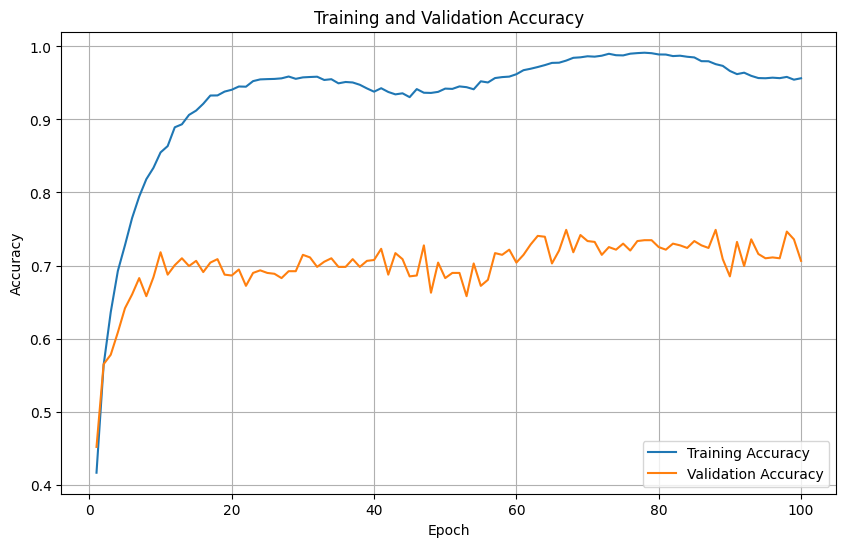

In [24]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
test_model(model, test_loader)

Test acc: 0.716


In [26]:
torch.save(model, './hopefully_better/cnn-seeded-noaugment-cosine')

# cnn lstm

In [36]:
class CLSTM(nn.Module):
    def __init__(self,
                 num_classes=4,
                 in_channels=22,
                 depth=25,
                 kernel1=3,
                 kernel2=(1, 22),
                 kernel3=5,
                 kernel4=5,
                 pool_kernel=(1, 3),
                 dropout=0.6,
                 hidden_dims=128,
                 num_layers=2):
        super(CLSTM, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=in_channels,
                                             out_channels=depth,
                                             kernel_size=kernel1,
                                             padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(depth),
                                   nn.Dropout(dropout))

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=depth,
                                             out_channels=depth*2,
                                             kernel_size=kernel2,
                                             stride=2),
                                   nn.ELU(),
                                   nn.BatchNorm2d(depth * 2),
                                   nn.AvgPool2d(kernel_size=(1, 3)),
                                   nn.Dropout(dropout))

        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=depth*2,
                                             out_channels=depth*4,
                                             kernel_size=kernel3),
                                   nn.ELU(),
                                   nn.BatchNorm1d(depth * 4),
                                   nn.AvgPool2d(kernel_size=pool_kernel),
                                   nn.Dropout(dropout))

        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=depth*4,
                                             out_channels=depth*8,
                                             kernel_size=kernel4,
                                             stride=3),
                                   nn.ELU(),
                                   nn.BatchNorm1d(depth * 8),
                                   nn.MaxPool2d(kernel_size=pool_kernel),
                                   nn.Dropout(dropout))

        self.lstm = nn.LSTM(input_size=depth*8,
                            hidden_size=hidden_dims,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout,
                            bias=True,
                            bidirectional=True)
        self.dense = nn.Linear(in_features=hidden_dims * 2,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
    
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
    
        x = self.conv3(x)
        x = self.conv4(x)
    
        x = torch.flatten(x, 1)
        x, _ = self.lstm(x)
        x = self.dense(x)
    
        return F.log_softmax(x, dim=1)


In [37]:
from torchinfo import summary

model = CLSTM().to(device)
summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CLSTM                                    [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 400]             --
│    └─Conv1d: 2-1                       [64, 25, 400]             1,675
│    └─ReLU: 2-2                         [64, 25, 400]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 400]             50
│    └─Dropout: 2-4                      [64, 25, 400]             --
├─Sequential: 1-2                        [64, 50, 1, 63]           --
│    └─Conv2d: 2-5                       [64, 50, 1, 190]          27,550
│    └─ELU: 2-6                          [64, 50, 1, 190]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 190]          100
│    └─AvgPool2d: 2-8                    [64, 50, 1, 63]           --
│    └─Dropout: 2-9                      [64, 50, 1, 63]           --
├─Sequential: 1-3                        [64, 100, 19]             --
│    └─

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.0001)

In [39]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.264, Val acc: 0.249, Val loss: 1.376
Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.306, Val acc: 0.269, Val loss: 1.263
Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.342, Val acc: 0.347, Val loss: 1.212
Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.370, Val acc: 0.401, Val loss: 1.244
Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.385, Val acc: 0.416, Val loss: 1.237
Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.420, Val loss: 1.159
Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.421, Val acc: 0.417, Val loss: 1.219
Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.429, Val acc: 0.438, Val loss: 1.195
Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.433, Val acc: 0.443, Val loss: 1.140
Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.449, Val acc: 0.432, Val loss: 1.140
Epoch 11


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.436, Val loss: 1.207
Epoch 12


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.452, Val acc: 0.449, Val loss: 1.238
Epoch 13


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.468, Val acc: 0.422, Val loss: 1.198
Epoch 14


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.458, Val acc: 0.452, Val loss: 1.224
Epoch 15


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.470, Val acc: 0.460, Val loss: 1.149
Epoch 16


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.479, Val acc: 0.425, Val loss: 1.160
Epoch 17


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.478, Val acc: 0.463, Val loss: 1.186
Epoch 18


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.486, Val acc: 0.465, Val loss: 1.100
Epoch 19


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.484, Val acc: 0.458, Val loss: 1.162
Epoch 20


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.483, Val acc: 0.482, Val loss: 1.130
Epoch 21


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.495, Val acc: 0.475, Val loss: 1.105
Epoch 22


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.485, Val acc: 0.465, Val loss: 1.152
Epoch 23


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.494, Val acc: 0.483, Val loss: 1.095
Epoch 24


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.498, Val acc: 0.489, Val loss: 1.118
Epoch 25


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.497, Val acc: 0.479, Val loss: 1.124
Epoch 26


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.492, Val acc: 0.460, Val loss: 1.179
Epoch 27


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.500, Val acc: 0.472, Val loss: 1.145
Epoch 28


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.486, Val acc: 0.485, Val loss: 1.168
Epoch 29


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.492, Val acc: 0.506, Val loss: 1.124
Epoch 30


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.502, Val acc: 0.443, Val loss: 1.164
Epoch 31


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.499, Val acc: 0.489, Val loss: 1.134
Epoch 32


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.492, Val acc: 0.471, Val loss: 1.122
Epoch 33


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.499, Val acc: 0.491, Val loss: 1.176
Epoch 34


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.499, Val acc: 0.492, Val loss: 1.122
Epoch 35


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.490, Val acc: 0.489, Val loss: 1.114
Epoch 36


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.487, Val acc: 0.485, Val loss: 1.144
Epoch 37


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.491, Val acc: 0.461, Val loss: 1.160
Epoch 38


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.498, Val acc: 0.487, Val loss: 1.157
Epoch 39


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.496, Val acc: 0.501, Val loss: 1.142
Epoch 40


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.480, Val acc: 0.476, Val loss: 1.101
Epoch 41


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.478, Val acc: 0.483, Val loss: 1.045
Epoch 42


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.489, Val acc: 0.522, Val loss: 1.181
Epoch 43


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.487, Val acc: 0.498, Val loss: 1.062
Epoch 44


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.480, Val acc: 0.488, Val loss: 1.183
Epoch 45


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.488, Val acc: 0.495, Val loss: 1.192
Epoch 46


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.489, Val acc: 0.429, Val loss: 1.219
Epoch 47


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.487, Val acc: 0.492, Val loss: 1.206
Epoch 48


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.486, Val acc: 0.486, Val loss: 1.184
Epoch 49


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.482, Val acc: 0.471, Val loss: 1.144
Epoch 50


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.482, Val acc: 0.460, Val loss: 1.223
Epoch 51


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.486, Val acc: 0.471, Val loss: 1.179
Epoch 52


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.486, Val acc: 0.459, Val loss: 1.139
Epoch 53


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.483, Val acc: 0.459, Val loss: 1.107
Epoch 54


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.484, Val acc: 0.438, Val loss: 1.192
Epoch 55


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.487, Val acc: 0.462, Val loss: 1.157
Epoch 56


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.481, Val acc: 0.467, Val loss: 1.140
Epoch 57


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.489, Val acc: 0.500, Val loss: 1.106
Epoch 58


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.498, Val acc: 0.468, Val loss: 1.139
Epoch 59


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.504, Val acc: 0.463, Val loss: 1.212
Epoch 60


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.492, Val acc: 0.483, Val loss: 1.184
Epoch 61


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.503, Val acc: 0.458, Val loss: 1.199
Epoch 62


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.505, Val acc: 0.492, Val loss: 1.175
Epoch 63


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.501, Val acc: 0.474, Val loss: 1.174
Epoch 64


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.504, Val acc: 0.466, Val loss: 1.143
Epoch 65


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.517, Val acc: 0.493, Val loss: 1.139
Epoch 66


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.514, Val acc: 0.468, Val loss: 1.083
Epoch 67


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.515, Val acc: 0.473, Val loss: 1.062
Epoch 68


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.491, Val loss: 1.077
Epoch 69


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.519, Val acc: 0.472, Val loss: 1.086
Epoch 70


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.521, Val acc: 0.489, Val loss: 1.105
Epoch 71


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.528, Val acc: 0.491, Val loss: 1.102
Epoch 72


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.524, Val acc: 0.487, Val loss: 1.110
Epoch 73


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.534, Val acc: 0.480, Val loss: 1.108
Epoch 74


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.522, Val acc: 0.482, Val loss: 1.100
Epoch 75


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.525, Val acc: 0.491, Val loss: 1.125
Epoch 76


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.533, Val acc: 0.487, Val loss: 1.109
Epoch 77


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.542, Val acc: 0.485, Val loss: 1.101
Epoch 78


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.530, Val acc: 0.489, Val loss: 1.129
Epoch 79


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.541, Val acc: 0.488, Val loss: 1.128
Epoch 80


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.529, Val acc: 0.481, Val loss: 1.123
Epoch 81


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.527, Val acc: 0.491, Val loss: 1.084
Epoch 82


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.533, Val acc: 0.480, Val loss: 1.095
Epoch 83


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.529, Val acc: 0.488, Val loss: 1.128
Epoch 84


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.529, Val acc: 0.492, Val loss: 1.120
Epoch 85


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.517, Val acc: 0.489, Val loss: 1.201
Epoch 86


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.485, Val loss: 1.233
Epoch 87


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.522, Val acc: 0.479, Val loss: 1.108
Epoch 88


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.492, Val loss: 1.109
Epoch 89


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.514, Val acc: 0.502, Val loss: 1.047
Epoch 90


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.516, Val acc: 0.492, Val loss: 1.235
Epoch 91


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.515, Val acc: 0.476, Val loss: 1.113
Epoch 92


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.512, Val acc: 0.504, Val loss: 1.094
Epoch 93


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.509, Val acc: 0.485, Val loss: 1.104
Epoch 94


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.510, Val acc: 0.494, Val loss: 1.133
Epoch 95


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.505, Val acc: 0.520, Val loss: 1.149
Epoch 96


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.503, Val acc: 0.479, Val loss: 1.097
Epoch 97


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.501, Val acc: 0.443, Val loss: 1.114
Epoch 98


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.511, Val acc: 0.491, Val loss: 1.133
Epoch 99


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.500, Val acc: 0.499, Val loss: 1.073
Epoch 100


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.503, Val acc: 0.469, Val loss: 1.109


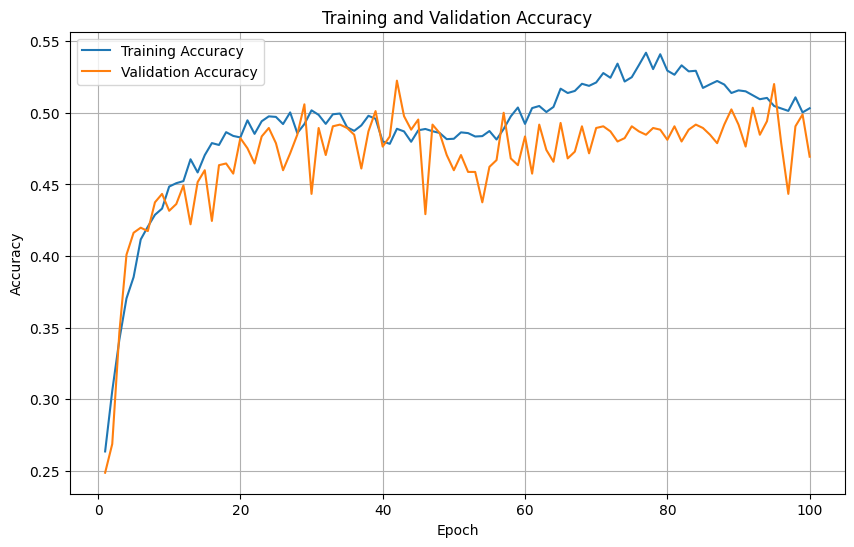

In [41]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
test_model(model, test_loader)

Test acc: 0.413


In [40]:
torch.save(model, './hopefully_better/clstm-seeded-noaugment-cosine')